<a href="https://colab.research.google.com/github/eduardodut/Topicos_ciencia_dados/blob/master/trabalho02_topicosavancadosCD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
CAMINHO_DATASETS = '/content/drive/My Drive/Mestrado/Material de estudo/TA Ciência de dados/Trabalho_aprendizado_semisupervisionado/datasets'
max_iter = 100 # máximo de iterações para as soluções iterativas

### Funções utilizadas

In [ ]:
import numpy as np
from scipy import sparse

def matriz_adjacencia(matriz_distancias, k):
  
  matriz_adjacencias = np.zeros(shape=(matriz_distancias.shape[0],matriz_distancias.shape[0]), dtype=np.int)
  
  for i in range(matriz_distancias.shape[0]):
    # cópia da linha
    array = matriz_distancias[i,:].copy()
    array[i] = np.NaN
    # ordenação e busca dos k primeiros
    indices = np.argsort(array)[0:k]
    # escrita na matriz de saída dos vizinhos encontrados
    matriz_adjacencias[i,indices] = 1

  return matriz_adjacencias

def calculo_sigma(matriz_distancias, matriz_adjacencia):
  # torna a matriz de distância original em uma matriz esparsa apenas com os pesos dos k mais próximos
  matriz_k_menores_pesos = np.multiply(matriz_distancias , matriz_adjacencia)
  # seleciona os maiores pesos de cada linha(axis=1), realiza a soma dos elementos e divide por 3 * o número de observações do dataset
  sigma = matriz_k_menores_pesos.max(axis = 1).sum()/(3*matriz_k_menores_pesos.shape[0])
  return sigma


def calculo_matriz_pesos(matriz_adjacencia, matriz_distancias, sigma):
  # torna a matriz de distância original em uma matriz esparça apenas com os pesos dos k mais próximos
  matriz_k_menores_distancias = np.multiply(matriz_distancias , matriz_adjacencia)
  # realiza o cálculo dos pesos, com a técnica do kernel rbf, apenas onde a matriz de adjacência for igual a 1.
  matriz_pesos = np.exp((-(matriz_k_menores_distancias * matriz_k_menores_distancias)) / (2*sigma*sigma), where= matriz_adjacencia == 1) 
 
  return np.multiply(matriz_pesos, matriz_adjacencia)
  # return matriz_pesos
# D
def matriz_diagonal_pesos(matriz_pesos):
  saida = np.zeros_like(matriz_pesos)
  soma_linha = matriz_pesos.sum(axis=1)
    
  return np.diag(soma_linha)

def laplaciano_combinatorio(matriz_pesos, gama=1.0):  # gama=1.01
    
  return gama*matriz_diagonal_pesos(matriz_pesos) - matriz_pesos

def laplaciano_normalizado(matriz_pesos):

  D = matriz_pesos.sum(axis=1)

  inversa_raiz_D = np.diag(D ** -0.5)

  identidade = np.eye(matriz_pesos.shape[0])


  return (inversa_raiz_D @ laplaciano_combinatorio(matriz_pesos) ) @ inversa_raiz_D
  # return identidade - ((inversa_raiz_D @ matriz_pesos) @ inversa_raiz_D)

#P
def matriz_transicao(D,W):
  return np.linalg.inv(D) @ (W)

def reorganizar_matriz(matriz, vetor_indices_l):
  vetor_indices_u = np.array([i for i in range(matriz.shape[0]) if i not in vetor_indices_l])
  # assume-se que a matriz é quadrada

  m_ll = matriz[vetor_indices_l][:,vetor_indices_l]
  m_ul = matriz[vetor_indices_u][:,vetor_indices_l]
  m_lu = matriz[vetor_indices_l][:,vetor_indices_u]
  m_uu = matriz[vetor_indices_u][:,vetor_indices_u]
  

  return m_ll, m_lu, m_ul, m_uu
  
def reorganizar_labels(y, vetor_indices_l):
  vetor_indices_u = np.array([i for i in range(y.shape[0]) if i not in vetor_indices_l])
  # assume-se que a matriz é quadrada

  y_l = y[vetor_indices_l]
  y_u = y[vetor_indices_u]
  

  return y_l, y_u  

## digit-1

### Leitura do dataset

In [ ]:
import pandas as pd
digit_1 = pd.read_csv(CAMINHO_DATASETS + '/digit-1.txt',header=None, sep=',')

In [ ]:
import numpy as np

X_digit1 = digit_1.loc[:, 0:240]
y_digit1 = digit_1[[241]]

for i in np.unique(y_digit1.values):
  
  y_digit1['classe_'+str(i)] = 1*(y_digit1[241] == i)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
y_digit1.shape

(1500, 3)

### Matriz de distâncias - Ψ

In [ ]:
import numpy as np
import pandas as pd
import os
def func_distancia(X_i, X_j):

  return np.sqrt(np.square(X_i - X_j).sum())


matriz_distancias_digit1 = np.zeros(shape=(X_digit1.shape[0],X_digit1.shape[0]))
if os.path.isfile(CAMINHO_DATASETS+'/digit-1-matriz_distancias.csv'):
  matriz_distancias_digit1 = pd.read_csv(CAMINHO_DATASETS+'/digit-1-matriz_distancias.csv',header=None, sep=',').values
else:
  for i in range(X_digit1.shape[0]):
    # print(i)
    for j in range(i+1, X_digit1.shape[0]):
      # print("  ", j)
      matriz_distancias_digit1[i,j] = func_distancia(X_digit1.loc[i], X_digit1.loc[j])
      matriz_distancias_digit1[j,i] = matriz_distancias_digit1[i,j]



  df = pd.DataFrame(data=matriz_distancias_digit1.astype(float))
  df.to_csv(CAMINHO_DATASETS+'/digit-1-matriz_distancias.csv', sep=',', header=False, float_format='%.4f', index=False)

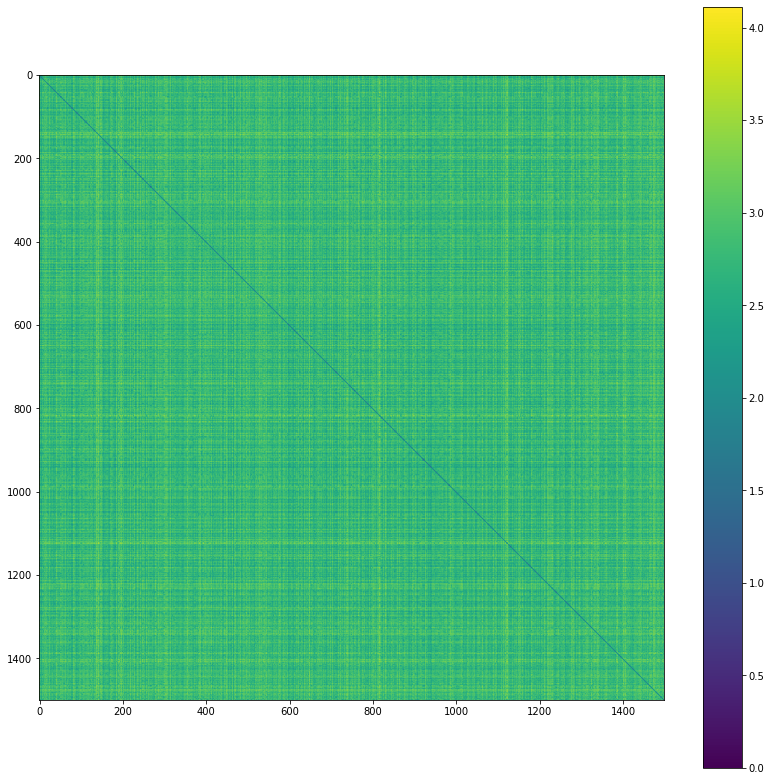

In [ ]:
import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(18, 2))

plt.figure(figsize = (14,14))
plt.imshow(matriz_distancias_digit1)
plt.colorbar()

### Grafo de adjacência, para k = 12 - Â

In [ ]:
matriz_adjacencia_digit1 = matriz_adjacencia(matriz_distancias_digit1, k = 12)

In [ ]:
matriz_adjacencia_digit1.sum()

18000

### Matriz de adjacência mútua - A

In [ ]:
matriz_adjacencia_mutua_digit1 = np.minimum(matriz_adjacencia_digit1,matriz_adjacencia_digit1.transpose())

In [ ]:
matriz_adjacencia_digit1.sum() - matriz_adjacencia_mutua_digit1.sum()

4208

In [ ]:
matriz_adjacencia_mutua_digit1[1091].sum()

1

### Estimando σ

In [ ]:
sigma_digit1 = calculo_sigma(matriz_distancias_digit1, matriz_adjacencia_mutua_digit1)
print("σ =", sigma_digit1)

σ = 0.5700733333333333


### Matriz de pesos das arestas - W



In [ ]:
matriz_peso_arestas_digit1 = calculo_matriz_pesos(matriz_adjacencia_mutua_digit1, #matriz adjacência mútua
                                                  matriz_distancias_digit1,       #matriz de distâncias
                                                  sigma_digit1)                   #sigma

In [ ]:
matriz_peso_arestas_digit1.trace()

0.0

In [ ]:
matriz_adjacencia_mutua_digit1[1091].sum()

1

(array([  6.,  15.,  38.,  56.,  83., 139., 194., 213., 228., 528.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <a list of 10 Patch objects>)

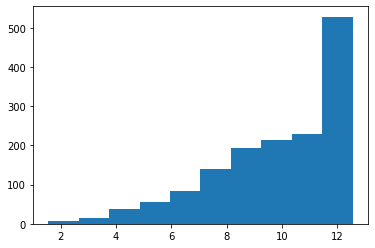

In [ ]:
import matplotlib.pyplot as plt

plt.hist(np.count_nonzero(matriz_peso_arestas_digit1,axis=1), align='right')


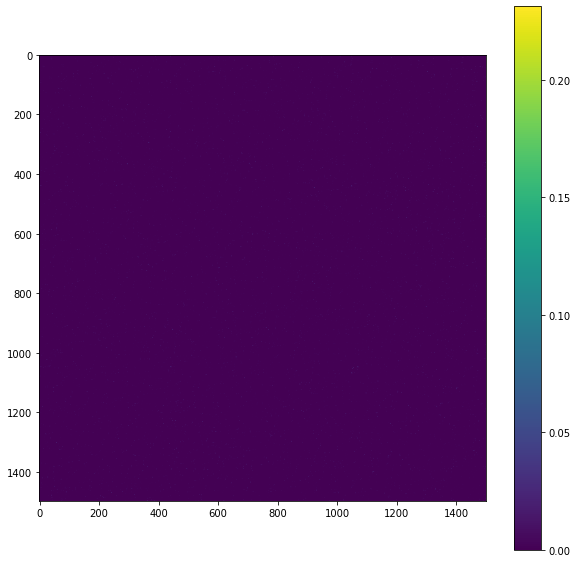

In [ ]:
import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(18, 2))

plt.figure(figsize = (10,10))
plt.imshow(matriz_peso_arestas_digit1)
plt.colorbar()

### Geração dos Laplacianos

In [ ]:
D_digit1 = matriz_diagonal_pesos(matriz_peso_arestas_digit1)

In [ ]:
Lc_digit1 = laplaciano_combinatorio(matriz_peso_arestas_digit1)
eigenvalues_Lc_digit1 = np.linalg.eigvals(Lc_digit1)

In [ ]:
Ln_digit1 = laplaciano_normalizado(matriz_peso_arestas_digit1)
eigenvalues_Ln_digit1 = np.linalg.eigvals(Ln_digit1)

#### Gráficos

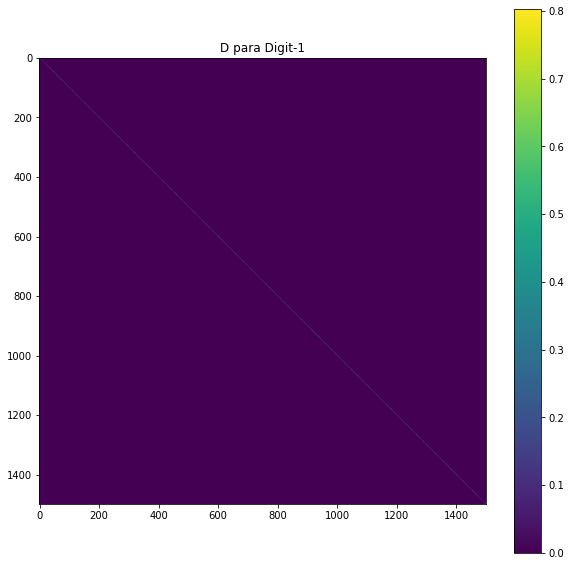

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(D_digit1)
plt.title('D para Digit-1')
plt.colorbar()

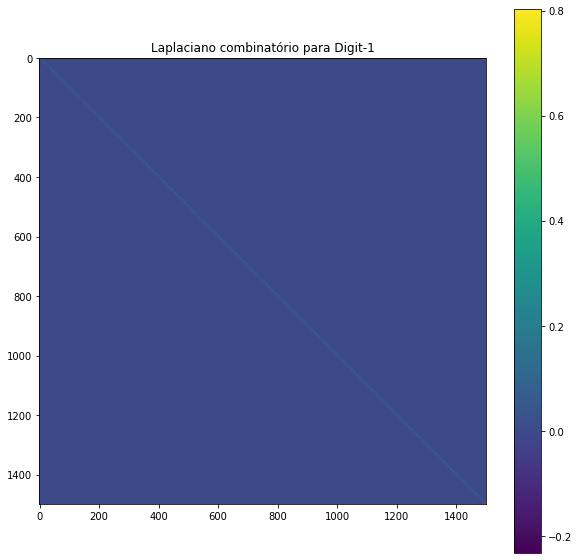

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(Lc_digit1)
plt.title('Laplaciano combinatório para Digit-1')
plt.colorbar()

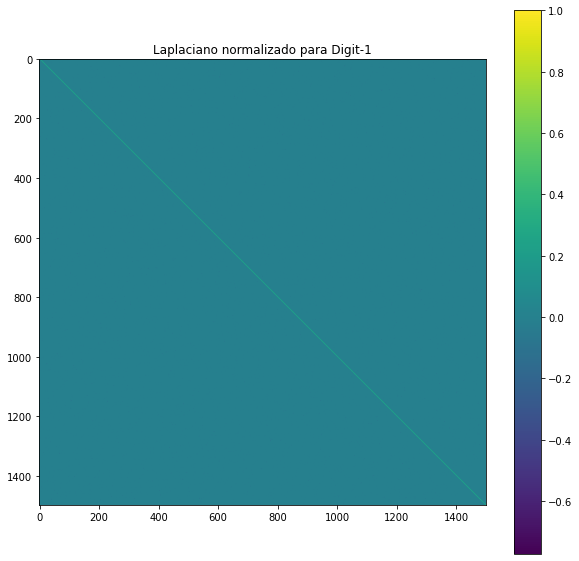

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(Ln_digit1)
plt.title('Laplaciano normalizado para Digit-1')
plt.colorbar()

### Matriz de transição

In [ ]:
import numpy as np
from scipy import sparse
# matriz_peso_arestas_digit1 = sparse.csr_matrix(matriz_peso_arestas_digit1) 
# D_digit1 = sparse.csr_matrix(D_digit1)

In [ ]:
P_digit1 = matriz_transicao(D_digit1, matriz_peso_arestas_digit1)
# sparse.linalg.inv(D_digit1).dot(matriz_peso_arestas_digit1)

### Aplicação da propagação de rótulos

In [ ]:
# leitura do arquivo de partições:
partitions_digit1 = pd.read_csv(CAMINHO_DATASETS + '/partitions_digit-1.txt',header=None, sep=',').values
partitions_digit1

array([[ 450,  524,  554,  767,  969, 1361],
       [ 122,  514,  642,  992, 1471, 1498],
       [ 176,  912, 1181, 1263, 1323, 1403],
       [  55,  287,  552,  569,  774, 1386],
       [ 201,  476,  543,  884, 1073, 1468],
       [ 596,  710,  791,  906, 1044, 1094],
       [ 237,  563,  916,  926, 1465, 1482],
       [ 104,  337,  342,  716, 1120, 1446],
       [ 146,  550,  759,  959, 1040, 1467],
       [ 394,  489,  505,  656,  806, 1391],
       [ 614,  893, 1034, 1117, 1304, 1402],
       [  72,  313,  472,  561,  574, 1200],
       [ 128,  306,  330,  583,  585,  643],
       [ 669,  823,  891,  949, 1042, 1474],
       [ 122,  588,  622,  659, 1028, 1388],
       [ 439,  565,  876, 1035, 1117, 1361],
       [  27,  694,  773,  839, 1015, 1459],
       [   8,  292,  499,  612, 1169, 1480],
       [ 314,  388,  662,  995, 1186, 1332],
       [ 336,  744,  834, 1045, 1198, 1446]])

Para demonstrar a aplicação dos algoritmos será utilizada a primeira lista de índices fornecida para o dataset

In [ ]:
f1_score_digit1 = {}

matriz_pesos = matriz_peso_arestas_digit1

particoes = partitions_digit1

labels = y_digit1.loc[particoes[0]][241]



print("índices das observações classificadas:",particoes[0])
print("Quantidade de observações com labels: ",particoes[0].shape[0])
print("Quantidade de observações sem labels: ",matriz_pesos.shape[0] - particoes[0].shape[0] )
print("Distribuição das classes: ")
print(labels.value_counts())

índices das observações classificadas: [ 450  524  554  767  969 1361]
Quantidade de observações com labels:  6
Quantidade de observações sem labels:  1494
Distribuição das classes: 
0    5
1    1
Name: 241, dtype: int64


#### Solução pela "forma fechada"
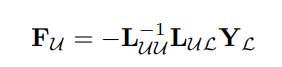

In [ ]:
particao = particoes[0]
L = reorganizar_matriz(Lc_digit1,particao )
Y = reorganizar_labels(y_digit1[['classe_0', 'classe_1']].values, particao)
Luu =  L[3]
Lul =  L[2]
Yl = Y[0]

# checando formato das matrizes
print("Formato da Luu (submatriz de Lc das observações não classificadas): ")
print(Luu.shape)
print("Formato da Lul (submatriz de Lc que contém as linhas das observações não classifcadas e as colunas das observações classificadas): ")
print(Lul.shape)
print("Formato da Yl (submatriz de Y que contém as classificações conhecidas): ")
print(Yl.shape)

# Propagação das labels
Fu = - np.linalg.inv(Luu) @ Lul @ Yl

print("Formato de Fu (resultado): ")
print(Fu.shape)

# classificação final das labels desconhecidas
ŷ = np.argmax(Fu, axis=1)

print("Distribuição de classes do resultado:")
print(pd.Series(ŷ).value_counts())

Formato da Luu (submatriz de Lc das observações não classificadas): 
(1494, 1494)
Formato da Lul (submatriz de Lc que contém as linhas das observações não classifcadas e as colunas das observações classificadas): 
(1494, 6)
Formato da Yl (submatriz de Y que contém as classificações conhecidas): 
(6, 2)
Formato de Fu (resultado): 
(1494, 2)
Distribuição de classes do resultado:
0    1493
1       1
dtype: int64


              precision    recall  f1-score   support

           0       0.51      1.00      0.68       761
           1       1.00      0.00      0.00       733

    accuracy                           0.51      1494
   macro avg       0.75      0.50      0.34      1494
weighted avg       0.75      0.51      0.35      1494



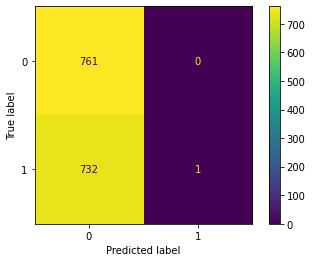

In [ ]:
#@markdown Classification report e matriz de confusão
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, plot_confusion_matrix

# classes alvo, correspondem às classes disponibilizadas, porém ignoradas para o teste

y = np.argmax(Y[1], axis=1)

# classes preditas após a difusão de labels
y_pred = ŷ

print(classification_report(y,y_pred))


class ClassificadorAdaptador(BaseEstimator, ClassifierMixin):

    def __init__(self, y):
        self.y = y
    def fit(self, X, y):
        return self
    def predict(self, X):
        return self.y[X]


# classificador para habilitar o uso da matriz de confusão
classificador = ClassificadorAdaptador(ŷ)

classificador.fit(range(ŷ.shape[0]),ŷ)

plot_confusion_matrix(classificador, 
                      range(ŷ.shape[0]), 
                      y, 
                      display_labels= [0,1],
                      values_format= ".0f")

##### Aplicação da solução para todas as partições

In [ ]:
from sklearn.metrics import f1_score
lista_f1 = []
for particao in particoes:
  # reorganiza Lc
  L = reorganizar_matriz(Lc_digit1, particao)
  # reorganiza labels
  Y = reorganizar_labels(y_digit1[['classe_0', 'classe_1']].values, particao)
  Luu =  L[3]
  Lul =  L[2]
  Yl = Y[0]
  Fu = - np.linalg.inv(Luu) @ Lul @ Yl
  # classificação final das labels desconhecidas
  ŷ = np.argmax(Fu, axis=1)

  # classificações verdadeiras
  y = np.argmax(Y[1], axis=1)
  lista_f1.append(f1_score(y,ŷ,average= 'macro'))
f1_score_digit1[0] = lista_f1

#### Soluções via Gaussian Fields and Harmonic Functions (GFHF)

##### GFHF para L = Lc

###### Cálculo da forma fechada
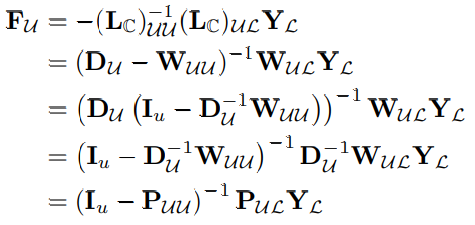

In [ ]:
particao = particoes[0]

# Matriz de transição dos elementos não classificados (uu):
P = reorganizar_matriz(P_digit1, particao )
Puu = P[3]

# Matriz de transição dos elementos não classificados e classificados (ul):
Pul = P[2]

# Matriz idendidade
Iu = np.eye(Puu.shape[0])

# submatriz das classes conhecidas
Y = reorganizar_labels(y_digit1[['classe_0', 'classe_1']].values, particao)
Yl = Y[0]

# checando formato das matrizes

print("Formato da Iuu (matriz identidade de dimensões uxu): ")
print(Iu.shape)
print("Formato da Puu (submatriz de transição que contém as observações não classificadas): ")
print(Puu.shape)
print("Formato da Pul (submatriz de transição que contém as linhas das observações não classificadas e as colunas das observações classificadas): ")
print(Pul.shape)
print("Formato da Yl (submatriz de Y que contém as classificações conhecidas): ")
print(Yl.shape)


Fu = np.linalg.inv(Iu - Puu) @ Pul @ Yl
# classificação final das labels desconhecidas
ŷ = np.argmax(Fu, axis=1)

print("Formato de Fu (resultado): ")
print(Fu.shape)

print("Distribuição de classes do resultado:")
print(pd.Series(ŷ).value_counts())


Formato da Iuu (matriz identidade de dimensões uxu): 
(1494, 1494)
Formato da Puu (submatriz de transição que contém as observações não classificadas): 
(1494, 1494)
Formato da Pul (submatriz de transição que contém as linhas das observações não classificadas e as colunas das observações classificadas): 
(1494, 6)
Formato da Yl (submatriz de Y que contém as classificações conhecidas): 
(6, 2)
Formato de Fu (resultado): 
(1494, 2)
Distribuição de classes do resultado:
0    1493
1       1
dtype: int64


              precision    recall  f1-score   support

           0       0.51      1.00      0.68       761
           1       1.00      0.00      0.00       733

    accuracy                           0.51      1494
   macro avg       0.75      0.50      0.34      1494
weighted avg       0.75      0.51      0.35      1494



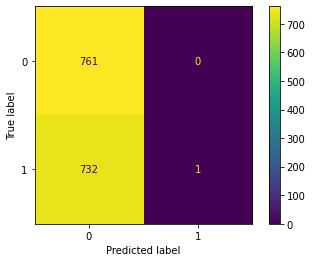

In [ ]:
#@markdown Classification report e matriz de confusão
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# classes alvo, correspondem às classes disponibilizadas, porém ignoradas para o teste
y =  np.argmax(Y[1], axis=1)

# classes preditas após a difusão de labels
y_pred = ŷ

print(classification_report(y,y_pred))


class ClassificadorAdaptador(BaseEstimator, ClassifierMixin):

    def __init__(self, y):
        self.y = y
    def fit(self, X, y):
        return self
    def predict(self, X):
        return self.y[X]


# classificador para habilitar o uso da matriz de confusão
classificador = ClassificadorAdaptador(ŷ)

classificador.fit(range(ŷ.shape[0]),ŷ)

plot_confusion_matrix(classificador, 
                      range(ŷ.shape[0]), 
                      y, 
                      display_labels= [0,1],
                      values_format= ".0f")

###### Aplicação da solução para todas as partições

In [ ]:
from sklearn.metrics import f1_score
lista_f1 = []
for particao in particoes:
  # reorganiza matriz de transição
  P = reorganizar_matriz(P_digit1, particao)
  # reorganiza labels
  Y = reorganizar_labels(y_digit1[['classe_0', 'classe_1']].values, particao)
  Puu = P[3]
  Pul = P[2]
  Yl = Y[0]
  # Matriz idendidade
  Iu = np.eye(Puu.shape[0])
  Fu = np.linalg.inv(Iu - Puu) @ Pul @ Yl
  # classificação final das labels desconhecidas
  ŷ = np.argmax(Fu, axis=1)

  # classificações verdadeiras
  y = np.argmax(Y[1], axis=1)
  lista_f1.append(f1_score(y,ŷ,average= 'macro'))
f1_score_digit1[1] = lista_f1

###### Cálculo iterativo
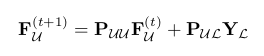

In [ ]:


particao = particoes[0]

# Matriz de transição dos elementos não classificados (uu):
P = reorganizar_matriz(P_digit1, particao )
Puu = P[3]

# Matriz de transição dos elementos não classificados e classificados (ul):
Pul = P[2]

# submatriz das classes conhecidas
Y = reorganizar_labels(y_digit1[['classe_0', 'classe_1']].values, particao)
Yl = Y[0]

# inicialização das variáveis
Fu = np.zeros_like(Y[1])
v = Pul @ Yl
for i in range(max_iter):
  Fu = Puu @ Fu + v

# classificação final das labels desconhecidas
ŷ = np.argmax(Fu, axis=1)

print(Fu.shape)

print("Distribuição de classes do resultado:")

print(pd.Series(ŷ).value_counts())

(1494, 2)
Distribuição de classes do resultado:
0    1267
1     227
dtype: int64


              precision    recall  f1-score   support

           0       0.60      1.00      0.75       761
           1       1.00      0.31      0.47       733

    accuracy                           0.66      1494
   macro avg       0.80      0.65      0.61      1494
weighted avg       0.80      0.66      0.61      1494



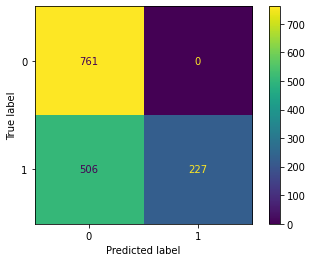

In [ ]:
#@markdown Classification report e matriz de confusão
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# classes alvo, correspondem às classes disponibilizadas, porém ignoradas para o teste
y =  np.argmax(Y[1], axis=1)

# classes preditas após a difusão de labels
y_pred = ŷ

print(classification_report(y,y_pred))


class ClassificadorAdaptador(BaseEstimator, ClassifierMixin):

    def __init__(self, y):
        self.y = y
    def fit(self, X, y):
        return self
    def predict(self, X):
        return self.y[X]


# classificador para habilitar o uso da matriz de confusão
classificador = ClassificadorAdaptador(ŷ)

classificador.fit(range(ŷ.shape[0]),ŷ)

plot_confusion_matrix(classificador, 
                      range(ŷ.shape[0]), 
                      y, 
                      display_labels= [0,1],
                      values_format= ".0f")

###### Aplicação da solução para todas as partições

In [ ]:
from sklearn.metrics import f1_score
lista_f1 = []

for particao in particoes:
  # reorganiza matriz de transição
  P = reorganizar_matriz(P_digit1, particao)
  # reorganiza labels
  Y = reorganizar_labels(y_digit1[['classe_0', 'classe_1']].values, particao)
  Puu = P[3]
  Pul = P[2]
  Yl = Y[0]

  # inicialização das variáveis
  Fu = np.zeros_like(Y[1])
  v = Pul @ Yl
  
  # convergência de Fu
  for i in range(max_iter):
    Fu = Puu @ Fu + v
  
  # classificação final das labels desconhecidas
  ŷ = np.argmax(Fu, axis=1)

  # classificações verdadeiras
  y = np.argmax(Y[1], axis=1)
  
  lista_f1.append(f1_score(y,ŷ, average= 'macro'))
f1_score_digit1[2] = lista_f1

##### GFHF para L = Ln

###### Cálculo da forma fechada
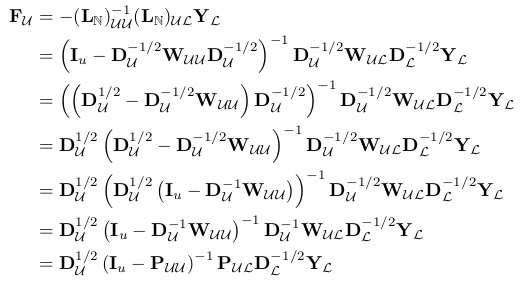

In [ ]:
particao = particoes[0]

# Matriz de transição dos elementos não classificados (uu):
P = reorganizar_matriz(P_digit1, particao )
Puu = P[3]

# Matriz de transição dos elementos não classificados e classificados (ul):
Pul = P[2]

# Matriz idendidade
Iu = np.eye(Puu.shape[0])

# D
D = reorganizar_matriz(D_digit1, particao)

Dll = np.diag(np.diag(D[0]) ** -0.5) # cálculo da raiz quadrada da inversa de Dll
Duu = np.diag(np.diag(D[3]) ** 0.5) # cálculo da raiz quadrada de Duu

# submatriz das classes conhecidas
Y = reorganizar_labels(y_digit1[['classe_0', 'classe_1']].values, particao)
Yl = Y[0]

Fu = Duu @ np.linalg.inv(Iu - Puu) @ Pul @ Dll @ Yl
# classificação final das labels desconhecidas
ŷ = np.argmax(Fu, axis=1)

print("Formato de Fu (resultado): ")
print(Fu.shape)

print("Distribuição de classes do resultado:")
print(pd.Series(ŷ).value_counts())


Formato de Fu (resultado): 
(1494, 2)
Distribuição de classes do resultado:
0    1490
1       4
dtype: int64


              precision    recall  f1-score   support

           0       0.51      1.00      0.68       761
           1       1.00      0.01      0.01       733

    accuracy                           0.51      1494
   macro avg       0.76      0.50      0.34      1494
weighted avg       0.75      0.51      0.35      1494



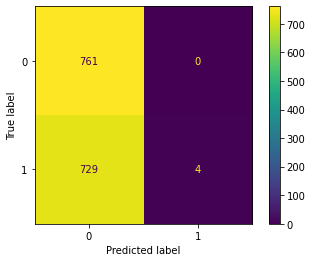

In [ ]:
#@markdown Classification report e matriz de confusão
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# classes alvo, correspondem às classes disponibilizadas, porém ignoradas para o teste
y =  np.argmax(Y[1], axis=1)

# classes preditas após a difusão de labels
y_pred = ŷ

print(classification_report(y,y_pred))


class ClassificadorAdaptador(BaseEstimator, ClassifierMixin):

    def __init__(self, y):
        self.y = y
    def fit(self, X, y):
        return self
    def predict(self, X):
        return self.y[X]


# classificador para habilitar o uso da matriz de confusão
classificador = ClassificadorAdaptador(ŷ)

classificador.fit(range(ŷ.shape[0]),ŷ)

plot_confusion_matrix(classificador, 
                      range(ŷ.shape[0]), 
                      y, 
                      display_labels= [0,1],
                      values_format= ".0f")

###### Aplicação da solução para todas as partições

In [ ]:
from sklearn.metrics import f1_score
lista_f1 = []
for particao in particoes:
  # reorganiza matriz de transição
  P = reorganizar_matriz(P_digit1, particao)
  # reorganiza labels
  Y = reorganizar_labels(y_digit1[['classe_0', 'classe_1']].values, particao)
  
  Puu = P[3]
  
  Pul = P[2]
  
  Yl = Y[0]
  # D
  D = reorganizar_matriz(D_digit1, particao)

  Dll = np.diag(np.diag(D[0]) ** -0.5) # cálculo da raiz quadrada da inversa de Dll
  Duu = np.diag(np.diag(D[3]) ** 0.5) # cálculo da raiz quadrada de Duu
  
  Iu = np.eye(Puu.shape[0])

  Fu = Duu @ np.linalg.inv(Iu - Puu) @ Pul @ Dll @ Yl
  # classificação final das labels desconhecidas
  ŷ = np.argmax(Fu, axis=1)

  # classificações verdadeiras
  y = np.argmax(Y[1], axis=1)
  lista_f1.append(f1_score(y,ŷ,average= 'macro'))
f1_score_digit1[3] = lista_f1

###### Cálculo iterativo
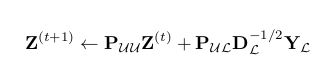

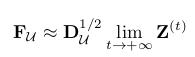

In [ ]:


particao = particoes[0]

# Matriz de transição dos elementos não classificados (uu):
P = reorganizar_matriz(P_digit1, particao )
Puu = P[3]

# Matriz de transição dos elementos não classificados e classificados (ul):
Pul = P[2]

# Matriz idendidade
Iu = np.eye(Puu.shape[0])

# D
D = reorganizar_matriz(D_digit1, particao)

Dll = np.diag(np.diag(D[0]) ** -0.5) # cálculo da raiz quadrada da inversa de Dll
Duu = np.diag(np.diag(D[3]) ** 0.5) # cálculo da raiz quadrada de Duu

# submatriz das classes conhecidas
Y = reorganizar_labels(y_digit1[['classe_0', 'classe_1']].values, particao)
Yl = Y[0]

# inicialização das variáveis
Fu = np.zeros_like(Y[1])
v = Pul @ Dll @ Yl
for i in range(max_iter):
  Fu = Puu @ Fu + v

Fu = Duu @ Fu
# classificação final das labels desconhecidas
ŷ = np.argmax(Fu, axis=1)

print(Fu.shape)

print("Distribuição de classes do resultado:")

print(pd.Series(ŷ).value_counts())

(1494, 2)
Distribuição de classes do resultado:
0    1231
1     263
dtype: int64


              precision    recall  f1-score   support

           0       0.61      0.99      0.76       761
           1       0.98      0.35      0.52       733

    accuracy                           0.68      1494
   macro avg       0.80      0.67      0.64      1494
weighted avg       0.80      0.68      0.64      1494



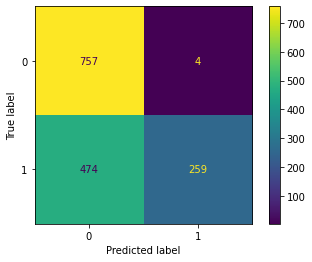

In [ ]:
#@markdown Classification report e matriz de confusão
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# classes alvo, correspondem às classes disponibilizadas, porém ignoradas para o teste
y =  np.argmax(Y[1], axis=1)

# classes preditas após a difusão de labels
y_pred = ŷ

print(classification_report(y,y_pred))


class ClassificadorAdaptador(BaseEstimator, ClassifierMixin):

    def __init__(self, y):
        self.y = y
    def fit(self, X, y):
        return self
    def predict(self, X):
        return self.y[X]


# classificador para habilitar o uso da matriz de confusão
classificador = ClassificadorAdaptador(ŷ)

classificador.fit(range(ŷ.shape[0]),ŷ)

plot_confusion_matrix(classificador, 
                      range(ŷ.shape[0]), 
                      y, 
                      display_labels= [0,1],
                      values_format= ".0f")

###### Aplicação da solução para todas as partições

In [ ]:
from sklearn.metrics import f1_score
lista_f1 = []

for particao in particoes:
  # Matriz de transição dos elementos não classificados (uu):
  P = reorganizar_matriz(P_digit1, particao )
  Puu = P[3]

  # Matriz de transição dos elementos não classificados e classificados (ul):
  Pul = P[2]

  # Matriz idendidade
  Iu = np.eye(Puu.shape[0])

  # D
  D = reorganizar_matriz(D_digit1, particao)

  Dll = np.diag(np.diag(D[0]) ** -0.5) # cálculo da raiz quadrada da inversa de Dll
  Duu = np.diag(np.diag(D[3]) ** 0.5) # cálculo da raiz quadrada de Duu

  # submatriz das classes conhecidas
  Y = reorganizar_labels(y_digit1[['classe_0', 'classe_1']].values, particao)
  Yl = Y[0]

  # inicialização das variáveis
  Fu = np.zeros_like(Y[1])
  v = Pul @ Dll @ Yl
  for i in range(max_iter):
    Fu = Puu @ Fu + v

  Fu = Duu @ Fu
  # classificação final das labels desconhecidas
  ŷ = np.argmax(Fu, axis=1)

  # classificações verdadeiras
  y = np.argmax(Y[1], axis=1)
  
  lista_f1.append(f1_score(y,ŷ, average= 'macro'))
f1_score_digit1[4] = lista_f1

#### Avaliação dos resultados

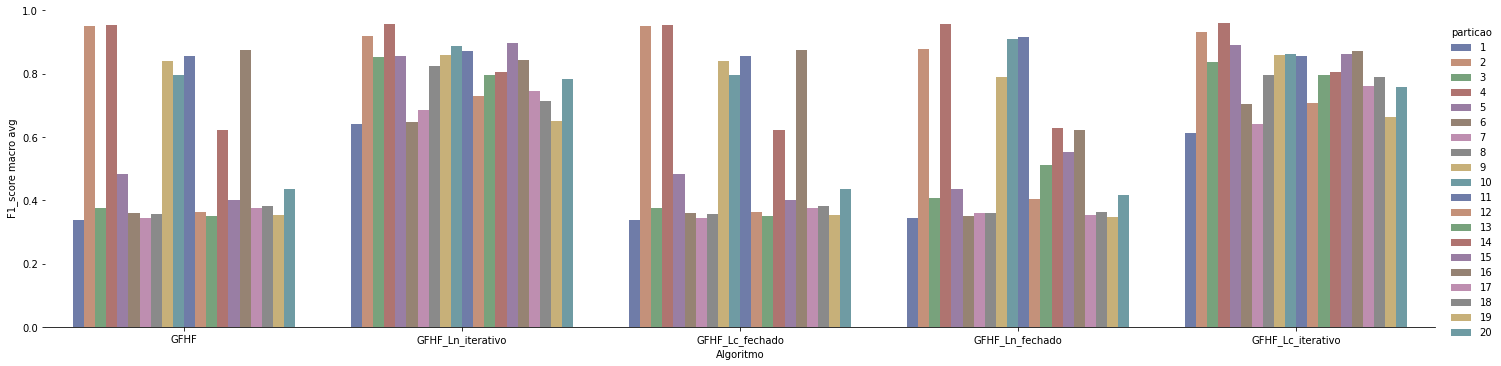

In [ ]:
import seaborn as sns
#@title  
df_resultados = pd.DataFrame(f1_score_digit1)
metodos=['GFHF', 'GFHF_Lc_fechado', 'GFHF_Lc_iterativo', 'GFHF_Ln_fechado', 'GFHF_Ln_iterativo']

df_resultados.columns = metodos
df_resultados['particao'] = df_resultados.index+1
df_resultados = pd.melt(df_resultados,
                        value_vars=metodos, 
                        id_vars='particao').sort_values('particao')

g = sns.catplot(
    data=df_resultados, kind="bar",
    x="variable", y="value", hue="particao",
    ci="sd", palette="dark", alpha=.6, height=5, aspect=20/5
)

g.set_axis_labels("Algoritmo", "F1_score macro avg")
g.despine(left=True)
# g.legend.set_title("")

## Re0

### Leitura do dataset

In [ ]:
import pandas as pd
import numpy as np
f = open(CAMINHO_DATASETS+'/Re0_wc.txt', 'r')
lista_dict = []
lista_classe = []
linhas = f.readlines()
bow = {}
for i,linha in enumerate(linhas):#iterando sobre as linhas do doc
  bow = dict()
  for cj in linha.split(","):#iterando sobre o par chave-valor
    itens = cj.split()
    if len(itens) > 1:# se não se tratar da classe (último elemento)
      bow[int(cj.split()[0])] = float(cj.split()[1])
      
    else:
      lista_classe.append(itens[0])
  
  lista_dict.append(bow)

df = pd.DataFrame(lista_dict)
df[df!=df] = 0.0
df = df[df.columns.sort_values()]

df['classe'] = lista_classe

df['classe'] = df['classe'].astype("int")

f.close()

In [ ]:
X_Re0 = df.drop(['classe'], axis=1)
y_Re0 = df[['classe']]
for i in np.unique(y_Re0.values):
  y_Re0['classe_'+str(i)] = 1*(y_Re0[['classe']] == i)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

### Matriz de distâncias - Ψ

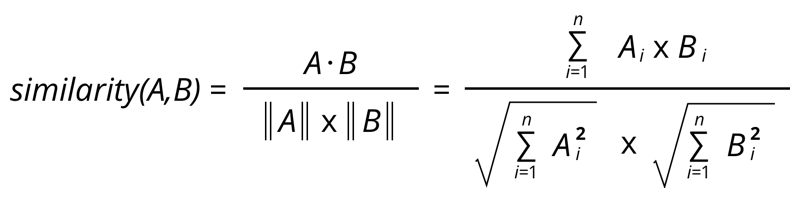

In [ ]:
dict_norma = {}

for i in range(X_Re0.shape[0]):
  dict_norma[i] = np.linalg.norm(X_Re0.loc[i])


In [ ]:
import numpy as np
def dot_product(dict1, dict2):
  lista_chaves_iguais = set(dict1.keys()).intersection(set(dict2.keys()))
  resultado = 0.0
  for chave in lista_chaves_iguais:
    resultado = resultado + dict1[chave] * dict2[chave]
  return resultado

matriz_similaridade = np.ones(shape=(df.shape[0],df.shape[0]))

#1504 x 1504

for i in range(X_Re0.shape[0]):
  # print(i)
  for j in range(i+1, X_Re0.shape[0]):
    # print("  ", j)
    matriz_similaridade[i,j] = dot_product(lista_dict[i],lista_dict[j])/(dict_norma[i]*dict_norma[j])
    matriz_similaridade[j,i] = matriz_similaridade[i,j]

# matriz_distancias_Re0 = matriz_similaridade + matriz_similaridade.transpose()

matriz_distancias_Re0 = 1 - matriz_similaridade

pd.DataFrame(matriz_distancias_Re0).to_csv(CAMINHO_DATASETS+'/re0-matriz_distancias.csv', sep=',', header=False, float_format='%.4f', index=False)

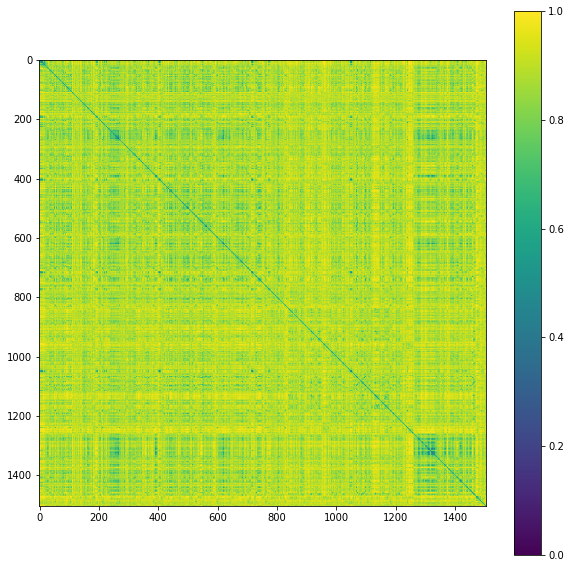

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize = (10,10))
plt.imshow(matriz_distancias_Re0)
plt.colorbar()

### Grafo de adjacência, para k = 70 - Â

In [ ]:
matriz_distancias_Re0 = pd.read_csv(CAMINHO_DATASETS+'/re0-matriz_distancias.csv',header=None, sep=',').values
matriz_adjacencia_Re0 = matriz_adjacencia(matriz_distancias_Re0, k = 70)

In [ ]:
matriz_adjacencia_Re0.sum(axis=1)

array([70, 70, 70, ..., 70, 70, 70])

### Matriz de adjacência mútua - A

In [ ]:
matriz_adjacencia_mutua_Re0 = np.minimum(matriz_adjacencia_Re0,matriz_adjacencia_Re0.transpose())

In [ ]:
qtd_vertices_isolados = 0
for i in range(matriz_adjacencia_mutua_Re0.shape[0]):
  qtd_vizinhos = (matriz_adjacencia_mutua_Re0[i] != 0).sum()
  if qtd_vizinhos == 0:
    qtd_vertices_isolados+=1
    print("vértice ",i,"está isolado")
print("qtd vértices isolados: ", qtd_vertices_isolados)

qtd vértices isolados:  0


### Estimando σ

In [ ]:
sigma_Re0 = calculo_sigma(matriz_distancias_Re0, matriz_adjacencia_mutua_Re0)
print("σ =", sigma_Re0)

σ = 0.20904718528368796


### Matriz de pesos das arestas - W



In [ ]:
matriz_peso_arestas_Re0 = calculo_matriz_pesos(matriz_adjacencia_mutua_Re0, #matriz adjacência
                                                  matriz_distancias_Re0,       #matriz de distâncias
                                                  sigma_Re0)                   #sigma

In [ ]:
matriz_peso_arestas_Re0.trace()

0.0

(array([ 78., 171., 171., 146., 141., 147., 144., 110., 123., 273.]),
 array([ 1. ,  7.9, 14.8, 21.7, 28.6, 35.5, 42.4, 49.3, 56.2, 63.1, 70. ]),
 <a list of 10 Patch objects>)

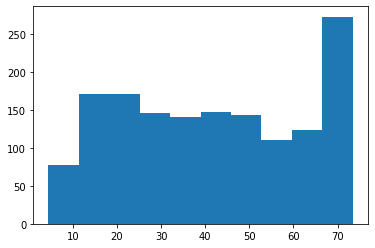

In [ ]:
import matplotlib.pyplot as plt

plt.hist(np.count_nonzero(matriz_peso_arestas_Re0,axis=1), align='right')


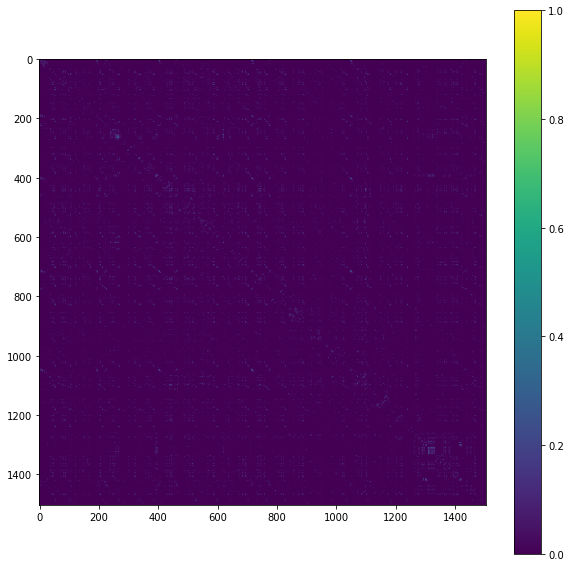

In [ ]:
import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(18, 2))

plt.figure(figsize = (10,10))
plt.imshow(matriz_peso_arestas_Re0)
plt.colorbar()

### Geração dos Laplacianos

In [ ]:
D_Re0 = matriz_diagonal_pesos(matriz_peso_arestas_Re0)

In [ ]:
Lc_Re0 = laplaciano_combinatorio(matriz_peso_arestas_Re0, gama=1.01)
eigenvalues_Lc_Re0 = np.linalg.eigvals(Lc_Re0)

In [ ]:
Ln_Re0 = laplaciano_normalizado(matriz_peso_arestas_Re0)
eigenvalues_Ln_Re0 = np.linalg.eigvals(Ln_Re0)

#### Gráficos

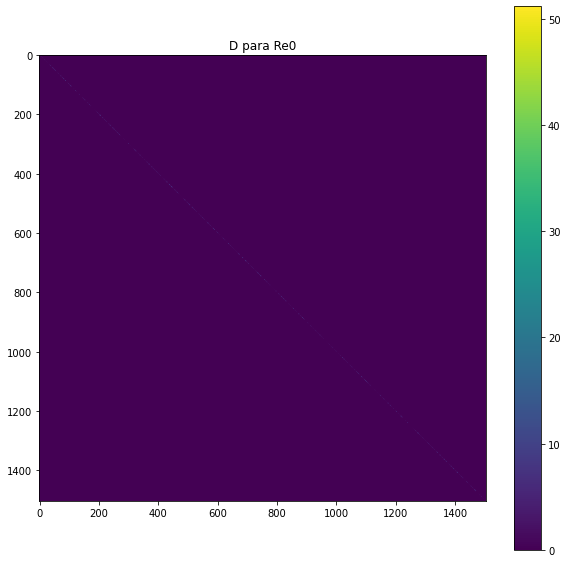

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(D_Re0)
plt.title('D para Re0')
plt.colorbar()

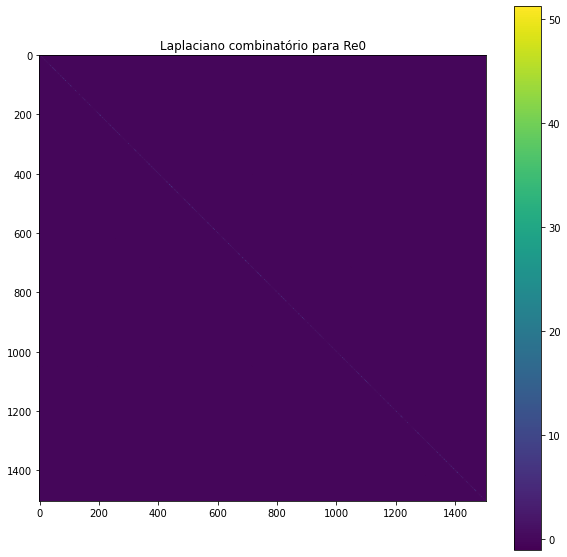

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(Lc_Re0)
plt.title('Laplaciano combinatório para Re0')
plt.colorbar()

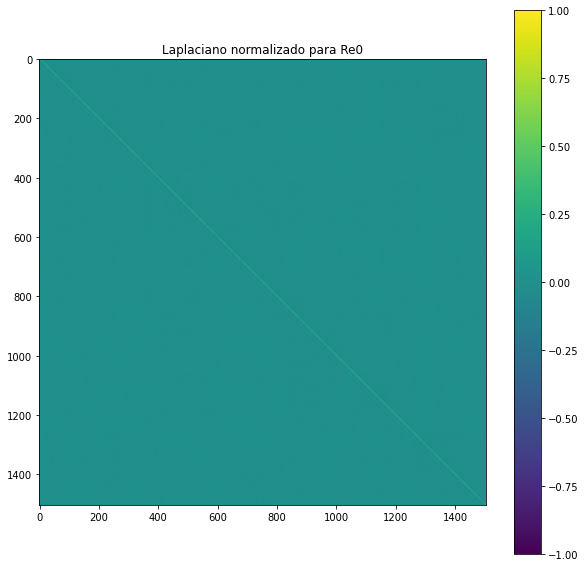

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(Ln_Re0)
plt.title('Laplaciano normalizado para Re0')
plt.colorbar()

### Matriz de transição

In [ ]:
P_Re0 = matriz_transicao(D_Re0, matriz_peso_arestas_Re0)

### Aplicação da propagação de rótulos

In [ ]:
# leitura do arquivo de partições:
partitions_Re0 = pd.read_csv(CAMINHO_DATASETS + '/partitions_Re0_wc.txt',header=None, sep=',').values
partitions_Re0

array([[  37,   41,  287,  299,  312,  364,  417,  439,  470,  480,  486,
         496,  557,  602,  617,  632,  640,  666,  671,  724,  730,  771,
         776,  797,  838,  869,  912,  939,  951,  959,  966, 1017, 1050,
        1186, 1203, 1332, 1443, 1464, 1467],
       [  55,  152,  198,  261,  313,  328,  398,  418,  441,  458,  480,
         539,  547,  634,  696,  713,  756,  771,  819,  870,  888,  895,
         950,  955, 1013, 1027, 1089, 1152, 1153, 1179, 1204, 1207, 1297,
        1381, 1404, 1430, 1464, 1470, 1502],
       [   0,    9,   61,   71,  100,  124,  128,  223,  240,  255,  322,
         336,  401,  411,  447,  481,  483,  541,  578,  617,  652,  673,
         735,  785,  857,  883, 1001, 1050, 1061, 1094, 1135, 1165, 1169,
        1228, 1401, 1413, 1468, 1469, 1475],
       [  37,   75,  113,  178,  300,  320,  346,  380,  411,  463,  502,
         548,  575,  579,  594,  642,  711,  737,  745,  746,  858,  943,
         945,  985, 1000, 1018, 1027, 1101, 1140, 1

Para demonstrar a aplicação dos algoritmos será utilizada a primeira lista de índices fornecida para o dataset

In [ ]:
f1_score_Re0 = {}

matriz_pesos = matriz_peso_arestas_Re0

particoes = partitions_Re0

labels = y_Re0.loc[particoes[0]]['classe']


print("índices das observações classificadas:",particoes[0])
print("Quantidade de observações com labels: ",particoes[0].shape[0])
print("Quantidade de observações sem labels: ",matriz_pesos.shape[0] - particoes[0].shape[0] )
print("Distribuição das classes: ")
print(labels.value_counts())

índices das observações classificadas: [  37   41  287  299  312  364  417  439  470  480  486  496  557  602
  617  632  640  666  671  724  730  771  776  797  838  869  912  939
  951  959  966 1017 1050 1186 1203 1332 1443 1464 1467]
Quantidade de observações com labels:  39
Quantidade de observações sem labels:  1465
Distribuição das classes: 
1     11
5      7
2      7
8      4
0      2
12     1
11     1
10     1
9      1
7      1
6      1
4      1
3      1
Name: classe, dtype: int64


#### Solução pela "forma fechada"
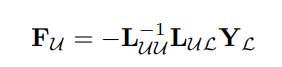

In [ ]:
# np.count_nonzero(Luu - np.diag(np.diagonal(Luu)))
np.all(Lc_Re0 == np.diag(np.diagonal(Lc_Re0)))

False

In [ ]:
particao = particoes[0]
L = reorganizar_matriz(Lc_Re0, particao)
Y = reorganizar_labels(y_Re0[y_Re0.columns[1:]].values, particao)
Luu =  L[3]
Lul =  L[2]
Yl = Y[0]

# checando formato das matrizes
print("Formato da Luu (submatriz de Lc das observações não classificadas): ")
print(Luu.shape)
print("Formato da Lul (submatriz de Lc que contém as linhas das observações não classifcadas e as colunas das observações classificadas): ")
print(Lul.shape)
print("Formato da Yl (submatriz de Y que contém as classificações conhecidas): ")
print(Yl.shape)

# Propagação das labels
# Foi utilizado gama= 1.01 para que Luu tivesse uma inversa
Fu = - np.linalg.inv(Luu) @ Lul @ Yl

print("Formato de Fu (resultado): ")
print(Fu.shape)

# classificação final das labels desconhecidas
ŷ = np.argmax(Fu, axis=1)

print("Distribuição de classes do resultado:")
print(pd.Series(ŷ).value_counts())

Formato da Luu (submatriz de Lc das observações não classificadas): 
(1465, 1465)
Formato da Lul (submatriz de Lc que contém as linhas das observações não classifcadas e as colunas das observações classificadas): 
(1465, 39)
Formato da Yl (submatriz de Y que contém as classificações conhecidas): 
(39, 13)
Formato de Fu (resultado): 
(1465, 13)
Distribuição de classes do resultado:
1     643
2     287
5     240
4     238
11     26
8      13
0      10
7       4
10      2
12      1
3       1
dtype: int64


              precision    recall  f1-score   support

           0       0.80      0.57      0.67        14
           1       0.74      0.80      0.77       597
           2       0.84      0.77      0.80       312
           3       0.00      0.00      0.00        41
           4       0.23      0.92      0.36        59
           5       0.69      0.78      0.73       212
           6       0.00      0.00      0.00        79
           7       1.00      0.21      0.35        19
           8       0.77      0.30      0.43        33
           9       0.00      0.00      0.00        38
          10       0.50      0.10      0.17        10
          11       0.27      0.19      0.22        37
          12       0.00      0.00      0.00        14

    accuracy                           0.66      1465
   macro avg       0.45      0.36      0.35      1465
weighted avg       0.64      0.66      0.63      1465



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


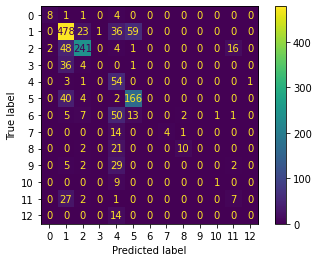

In [ ]:
#@markdown Classification report e matriz de confusão
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, plot_confusion_matrix

# classes alvo, correspondem às classes disponibilizadas, porém ignoradas para o teste

y = np.argmax(Y[1], axis=1)
lista_classes = np.unique(y)
# classes preditas após a difusão de labels
y_pred = ŷ

print(classification_report(y,y_pred))


class ClassificadorAdaptador(BaseEstimator, ClassifierMixin):

    def __init__(self, y):
        self.y = y
    def fit(self, X, y):
        return self
    def predict(self, X):
        return self.y[X]


# classificador para habilitar o uso da matriz de confusão
classificador = ClassificadorAdaptador(ŷ)

classificador.fit(range(ŷ.shape[0]),ŷ)

plot_confusion_matrix(classificador, 
                      range(ŷ.shape[0]), 
                      y, 
                      display_labels= lista_classes,
                      values_format= ".0f")

##### Aplicação da solução para todas as partições

In [ ]:
from sklearn.metrics import f1_score
lista_f1 = []
for particao in particoes:
  # reorganiza Lc
  L = reorganizar_matriz(Lc_Re0, particao)
  # reorganiza labels
  Y = reorganizar_labels(y_Re0[y_Re0.columns[1:]].values, particao)
  Luu =  L[3]
  Lul =  L[2]
  Yl = Y[0]
  Fu = - np.linalg.inv(Luu) @ Lul @ Yl
  # classificação final das labels desconhecidas
  ŷ = np.argmax(Fu, axis=1)

  # classificações verdadeiras
  y = np.argmax(Y[1], axis=1)
  lista_f1.append(f1_score(y,ŷ,average= 'macro'))
f1_score_Re0[0] = lista_f1

#### Soluções via Gaussian Fields and Harmonic Functions (GFHF)

##### GFHF para L = Lc

###### Cálculo da forma fechada
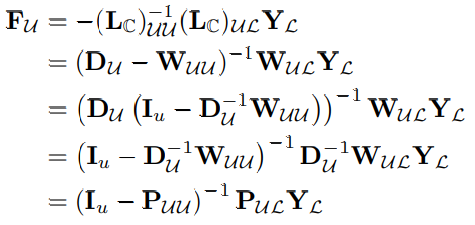

In [ ]:
L = reorganizar_matriz(laplaciano_combinatorio(matriz_peso_arestas_Re0, gama=1.01),particao)

In [ ]:
L[2].shape

(1465, 39)

In [ ]:
- np.linalg.inv(L[3]) @ L[2] @ Yl

array([[-3.66745735e-01, -4.45365609e-02, -3.12508311e-02, ...,
        -2.26339276e-03, -5.58290711e-02, -7.67705881e-02],
       [-2.75292446e-03, -4.19201520e-01, -1.18650049e-01, ...,
        -3.61674492e-04, -9.68564014e-02, -1.31059758e-02],
       [-3.10437649e-03, -1.87397118e-01, -2.47661181e-01, ...,
        -7.22889445e-04, -5.26602320e-02, -2.46239471e-02],
       ...,
       [-1.83445186e-03, -2.45631751e-01, -6.51423436e-02, ...,
        -3.91922285e-04, -1.25060380e-02, -1.46555603e-02],
       [-1.26556907e-02, -4.74188378e-02, -1.38879288e-01, ...,
        -4.32709148e-03, -1.72455588e-02, -1.19134007e-01],
       [-2.32347748e-03, -1.83067043e-01, -2.31424932e-01, ...,
        -4.30726877e-04, -5.77908123e-02, -1.59673544e-02]])

In [ ]:
# foi necessário utilizar essa resolução pois Iu - Luu não possui inversa
particao = particoes[0]

# Matriz de transição dos elementos não classificados (uu):
L = reorganizar_matriz( Lc_Re0,particao)
Luu = L[3]

# Matriz de transição dos elementos não classificados e classificados (ul):
Lul = L[2]

# submatriz das classes conhecidas
Y = reorganizar_labels(y_Re0[y_Re0.columns[1:]].values, particao)
Yl = Y[0]

# checando formato das matrizes

# print("Formato da Iuu (matriz identidade de dimensões uxu): ")
# print(Iu.shape)
print("Formato da Luu (submatriz de transição que contém as observações não classificadas): ")
print(Luu.shape)
print("Formato da Lul (submatriz de transição que contém as linhas das observações não classificadas e as colunas das observações classificadas): ")
print(Lul.shape)
print("Formato da Yl (submatriz de Y que contém as classificações conhecidas): ")
print(Yl.shape)


Fu = - np.linalg.inv(Luu) @ Lul @ Yl
# classificação final das labels desconhecidas
ŷ = np.argmax(Fu, axis=1)

print("Formato de Fu (resultado): ")
print(Fu.shape)

print("Distribuição de classes do resultado:")
print(pd.Series(ŷ).value_counts())


Formato da Luu (submatriz de transição que contém as observações não classificadas): 
(1465, 1465)
Formato da Lul (submatriz de transição que contém as linhas das observações não classificadas e as colunas das observações classificadas): 
(1465, 39)
Formato da Yl (submatriz de Y que contém as classificações conhecidas): 
(39, 13)
Formato de Fu (resultado): 
(1465, 13)
Distribuição de classes do resultado:
1     643
2     287
5     240
4     238
11     26
8      13
0      10
7       4
10      2
12      1
3       1
dtype: int64


              precision    recall  f1-score   support

           0       0.80      0.57      0.67        14
           1       0.74      0.80      0.77       597
           2       0.84      0.77      0.80       312
           3       0.00      0.00      0.00        41
           4       0.23      0.92      0.36        59
           5       0.69      0.78      0.73       212
           6       0.00      0.00      0.00        79
           7       1.00      0.21      0.35        19
           8       0.77      0.30      0.43        33
           9       0.00      0.00      0.00        38
          10       0.50      0.10      0.17        10
          11       0.27      0.19      0.22        37
          12       0.00      0.00      0.00        14

    accuracy                           0.66      1465
   macro avg       0.45      0.36      0.35      1465
weighted avg       0.64      0.66      0.63      1465



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


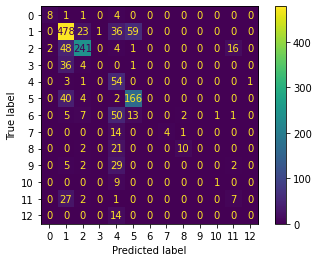

In [ ]:
#@markdown Classification report e matriz de confusão
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# classes alvo, correspondem às classes disponibilizadas, porém ignoradas para o teste
y =  np.argmax(Y[1], axis=1)
lista_classes = np.unique(y)
# classes preditas após a difusão de labels
y_pred = ŷ

print(classification_report(y,y_pred))


class ClassificadorAdaptador(BaseEstimator, ClassifierMixin):

    def __init__(self, y):
        self.y = y
    def fit(self, X, y):
        return self
    def predict(self, X):
        return self.y[X]


# classificador para habilitar o uso da matriz de confusão
classificador = ClassificadorAdaptador(ŷ)

classificador.fit(range(ŷ.shape[0]),ŷ)

plot_confusion_matrix(classificador, 
                      range(ŷ.shape[0]), 
                      y, 
                      display_labels= lista_classes,
                      values_format= ".0f")

###### Aplicação da solução para todas as partições

In [ ]:
from sklearn.metrics import f1_score
lista_f1 = []
for particao in particoes:
  # reorganiza matriz de transição
  L = reorganizar_matriz(Lc_Re0, particao)
  # reorganiza labels
  Y = reorganizar_labels(y_Re0[y_Re0.columns[1:]].values, particao)
  Luu = L[3]
  Lul = L[2]
  Yl = Y[0]
  # # Matriz idendidade
  # Iu = np.eye(Puu.shape[0])
  
  Fu = - np.linalg.inv(Luu) @ Lul @ Yl
  # classificação final das labels desconhecidas
  ŷ = np.argmax(Fu, axis=1)

  # classificações verdadeiras
  y = np.argmax(Y[1], axis=1)
  lista_f1.append(f1_score(y,ŷ,average= 'macro'))
f1_score_Re0[1] = lista_f1

###### Cálculo iterativo
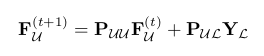

In [ ]:


particao = particoes[0]

# Matriz de transição dos elementos não classificados (uu):
P = reorganizar_matriz(P_Re0, particao )
Puu = P[3]

# Matriz de transição dos elementos não classificados e classificados (ul):
Pul = P[2]

# submatriz das classes conhecidas
Y = reorganizar_labels(y_Re0[y_Re0.columns[1:]].values, particao)
Yl = Y[0]

# inicialização das variáveis
Fu = np.zeros_like(Y[1])
v = Pul @ Yl
for i in range(max_iter):
  Fu = Puu @ Fu + v

# classificação final das labels desconhecidas
ŷ = np.argmax(Fu, axis=1)

print(Fu.shape)

print("Distribuição de classes do resultado:")

print(pd.Series(ŷ).value_counts())

(1465, 13)
Distribuição de classes do resultado:
1     660
2     279
4     243
5     237
11     22
8      11
0       9
10      2
7       2
dtype: int64


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.78      0.50      0.61        14
           1       0.73      0.80      0.76       597
           2       0.86      0.77      0.81       312
           3       0.00      0.00      0.00        41
           4       0.23      0.93      0.36        59
           5       0.69      0.77      0.73       212
           6       0.00      0.00      0.00        79
           7       1.00      0.11      0.19        19
           8       0.73      0.24      0.36        33
           9       0.00      0.00      0.00        38
          10       0.50      0.10      0.17        10
          11       0.27      0.16      0.20        37
          12       0.00      0.00      0.00        14

    accuracy                           0.66      1465
   macro avg       0.44      0.34      0.32      1465
weighted avg       0.64      0.66      0.63      1465



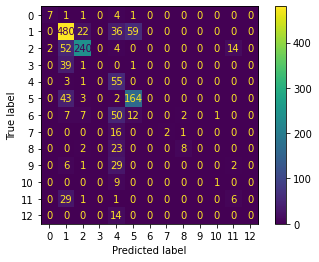

In [ ]:
#@markdown Classification report e matriz de confusão
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# classes alvo, correspondem às classes disponibilizadas, porém ignoradas para o teste
y =  np.argmax(Y[1], axis=1)
lista_classes = np.unique(y)
# classes preditas após a difusão de labels
y_pred = ŷ

print(classification_report(y,y_pred))


class ClassificadorAdaptador(BaseEstimator, ClassifierMixin):

    def __init__(self, y):
        self.y = y
    def fit(self, X, y):
        return self
    def predict(self, X):
        return self.y[X]


# classificador para habilitar o uso da matriz de confusão
classificador = ClassificadorAdaptador(ŷ)

classificador.fit(range(ŷ.shape[0]),ŷ)

plot_confusion_matrix(classificador, 
                      range(ŷ.shape[0]), 
                      y, 
                      display_labels= lista_classes,
                      values_format= ".0f")

###### Aplicação da solução para todas as partições

In [ ]:
from sklearn.metrics import f1_score
lista_f1 = []

for particao in particoes:
  # reorganiza matriz de transição
  P = reorganizar_matriz(P_Re0, particao)
  # reorganiza labels
  Y = reorganizar_labels(y_Re0[y_Re0.columns[1:]].values, particao)
  Puu = P[3]
  Pul = P[2]
  Yl = Y[0]

  # inicialização das variáveis
  Fu = np.zeros_like(Y[1])
  v = Pul @ Yl
  
  # convergência de Fu
  for i in range(max_iter):
    Fu = Puu @ Fu + v
  
  # classificação final das labels desconhecidas
  ŷ = np.argmax(Fu, axis=1)

  # classificações verdadeiras
  y = np.argmax(Y[1], axis=1)
  
  lista_f1.append(f1_score(y,ŷ, average= 'macro'))
f1_score_Re0[2] = lista_f1

##### GFHF para L = Ln

###### Cálculo da forma fechada
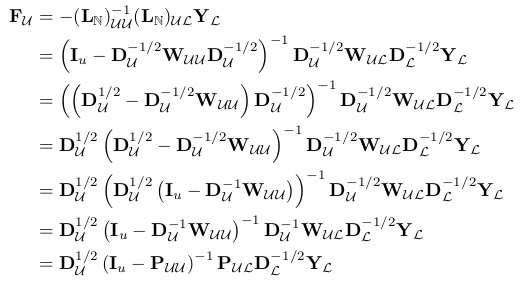

In [ ]:
particao = particoes[0]

# Matriz de transição dos elementos não classificados (uu):
P = reorganizar_matriz(P_Re0, particao )
Puu = P[3]

# Matriz de transição dos elementos não classificados e classificados (ul):
Pul = P[2]

# Matriz idendidade
Iu = np.eye(Puu.shape[0])

# D
D = reorganizar_matriz(D_Re0, particao)

Dll = np.diag(np.diag(D[0]) ** -0.5) # cálculo da raiz quadrada da inversa de Dll
Duu = np.diag(np.diag(D[3]) ** 0.5) # cálculo da raiz quadrada de Duu

# submatriz das classes conhecidas
Y = reorganizar_labels(y_Re0[y_Re0.columns[1:]].values, particao)
Yl = Y[0]
# foi utilizada a pseudoinversa
Fu = Duu @ np.linalg.pinv(Iu - Puu) @ Pul @ Dll @ Yl
# classificação final das labels desconhecidas
ŷ = np.argmax(Fu, axis=1)

print("Formato de Fu (resultado): ")
print(Fu.shape)

print("Distribuição de classes do resultado:")
print(pd.Series(ŷ).value_counts())


Formato de Fu (resultado): 
(1465, 13)
Distribuição de classes do resultado:
1     689
5     296
2     283
8      72
4      70
0      11
11     10
7      10
9       9
12      7
10      4
6       4
dtype: int64


              precision    recall  f1-score   support

           0       1.00      0.79      0.88        14
           1       0.71      0.82      0.76       597
           2       0.84      0.76      0.80       312
           3       0.00      0.00      0.00        41
           4       0.60      0.71      0.65        59
           5       0.54      0.75      0.63       212
           6       1.00      0.05      0.10        79
           7       1.00      0.53      0.69        19
           8       0.38      0.82      0.51        33
           9       1.00      0.24      0.38        38
          10       0.50      0.20      0.29        10
          11       0.40      0.11      0.17        37
          12       0.57      0.29      0.38        14

    accuracy                           0.68      1465
   macro avg       0.66      0.47      0.48      1465
weighted avg       0.70      0.68      0.65      1465



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


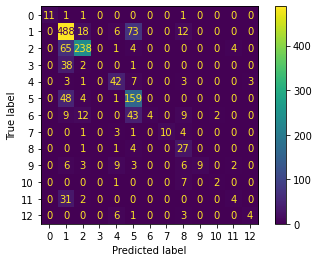

In [ ]:
#@markdown Classification report e matriz de confusão
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# classes alvo, correspondem às classes disponibilizadas, porém ignoradas para o teste
y =  np.argmax(Y[1], axis=1)
lista_classes = np.unique(y)
# classes preditas após a difusão de labels
y_pred = ŷ

print(classification_report(y,y_pred))


class ClassificadorAdaptador(BaseEstimator, ClassifierMixin):

    def __init__(self, y):
        self.y = y
    def fit(self, X, y):
        return self
    def predict(self, X):
        return self.y[X]


# classificador para habilitar o uso da matriz de confusão
classificador = ClassificadorAdaptador(ŷ)

classificador.fit(range(ŷ.shape[0]),ŷ)

plot_confusion_matrix(classificador, 
                      range(ŷ.shape[0]), 
                      y, 
                      display_labels= lista_classes,
                      values_format= ".0f")

###### Aplicação da solução para todas as partições

In [ ]:
from sklearn.metrics import f1_score
lista_f1 = []
for particao in particoes:
  # reorganiza matriz de transição
  P = reorganizar_matriz(P_Re0, particao)
  # reorganiza labels
  Y = reorganizar_labels(y_Re0[y_Re0.columns[1:]].values, particao)
  
  Puu = P[3]
  
  Pul = P[2]
  
  Yl = Y[0]
  # D
  D = reorganizar_matriz(D_Re0, particao)

  Dll = np.diag(np.diag(D[0]) ** -0.5) # cálculo da raiz quadrada da inversa de Dll
  Duu = np.diag(np.diag(D[3]) ** 0.5) # cálculo da raiz quadrada de Duu
  
  Iu = np.eye(Puu.shape[0])

  #pseudo inversa
  Fu = Duu @ np.linalg.pinv(Iu - Puu) @ Pul @ Dll @ Yl
  # classificação final das labels desconhecidas
  ŷ = np.argmax(Fu, axis=1)

  # classificações verdadeiras
  y = np.argmax(Y[1], axis=1)
  lista_f1.append(f1_score(y,ŷ,average= 'macro'))
f1_score_Re0[3] = lista_f1

###### Cálculo iterativo
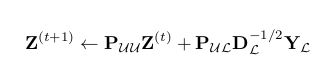

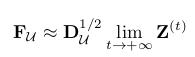

In [ ]:


particao = particoes[0]

# Matriz de transição dos elementos não classificados (uu):
P = reorganizar_matriz(P_Re0, particao )
Puu = P[3]

# Matriz de transição dos elementos não classificados e classificados (ul):
Pul = P[2]

# Matriz idendidade
Iu = np.eye(Puu.shape[0])

# D
D = reorganizar_matriz(D_Re0, particao)

Dll = np.diag(np.diag(D[0]) ** -0.5) # cálculo da raiz quadrada da inversa de Dll
Duu = np.diag(np.diag(D[3]) ** 0.5) # cálculo da raiz quadrada de Duu

# submatriz das classes conhecidas
Y = reorganizar_labels(y_Re0[y_Re0.columns[1:]].values, particao)
Yl = Y[0]

# inicialização das variáveis
Fu = np.zeros_like(Y[1])
v = Pul @ Dll @ Yl
for i in range(max_iter):
  Fu = Puu @ Fu + v

Fu = Duu @ Fu
# classificação final das labels desconhecidas
ŷ = np.argmax(Fu, axis=1)

print(Fu.shape)

print("Distribuição de classes do resultado:")

print(pd.Series(ŷ).value_counts())

(1465, 13)
Distribuição de classes do resultado:
1     656
2     302
5     288
8      83
4      72
11     16
0      13
7      10
9       9
12      7
6       5
10      4
dtype: int64


              precision    recall  f1-score   support

           0       0.85      0.79      0.81        14
           1       0.72      0.79      0.76       597
           2       0.80      0.78      0.79       312
           3       0.00      0.00      0.00        41
           4       0.58      0.71      0.64        59
           5       0.56      0.76      0.65       212
           6       1.00      0.06      0.12        79
           7       1.00      0.53      0.69        19
           8       0.33      0.82      0.47        33
           9       1.00      0.24      0.38        38
          10       0.50      0.20      0.29        10
          11       0.38      0.16      0.23        37
          12       0.57      0.29      0.38        14

    accuracy                           0.68      1465
   macro avg       0.64      0.47      0.48      1465
weighted avg       0.70      0.68      0.65      1465



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


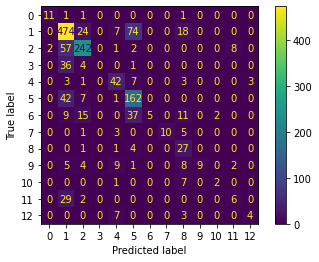

In [ ]:
#@markdown Classification report e matriz de confusão
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# classes alvo, correspondem às classes disponibilizadas, porém ignoradas para o teste
y =  np.argmax(Y[1], axis=1)
lista_classes = np.unique(y)
# classes preditas após a difusão de labels
y_pred = ŷ

print(classification_report(y,y_pred))


class ClassificadorAdaptador(BaseEstimator, ClassifierMixin):

    def __init__(self, y):
        self.y = y
    def fit(self, X, y):
        return self
    def predict(self, X):
        return self.y[X]


# classificador para habilitar o uso da matriz de confusão
classificador = ClassificadorAdaptador(ŷ)

classificador.fit(range(ŷ.shape[0]),ŷ)

plot_confusion_matrix(classificador, 
                      range(ŷ.shape[0]), 
                      y, 
                      display_labels=lista_classes,
                      values_format= ".0f")

###### Aplicação da solução para todas as partições

In [ ]:
from sklearn.metrics import f1_score
lista_f1 = []

for particao in particoes:
  # Matriz de transição dos elementos não classificados (uu):
  P = reorganizar_matriz(P_Re0, particao )
  Puu = P[3]

  # Matriz de transição dos elementos não classificados e classificados (ul):
  Pul = P[2]

  # Matriz idendidade
  Iu = np.eye(Puu.shape[0])

  # D
  D = reorganizar_matriz(D_Re0, particao)

  Dll = np.diag(np.diag(D[0]) ** -0.5) # cálculo da raiz quadrada da inversa de Dll
  Duu = np.diag(np.diag(D[3]) ** 0.5) # cálculo da raiz quadrada de Duu

  # submatriz das classes conhecidas
  Y = reorganizar_labels(y_Re0[y_Re0.columns[1:]].values, particao)
  Yl = Y[0]

  # inicialização das variáveis
  Fu = np.zeros_like(Y[1])
  v = Pul @ Dll @ Yl
  for i in range(max_iter):
    Fu = Puu @ Fu + v

  Fu = Duu @ Fu
  # classificação final das labels desconhecidas
  ŷ = np.argmax(Fu, axis=1)

  # classificações verdadeiras
  y = np.argmax(Y[1], axis=1)
  
  lista_f1.append(f1_score(y,ŷ, average= 'macro'))
f1_score_Re0[4] = lista_f1

#### Avaliação dos resultados

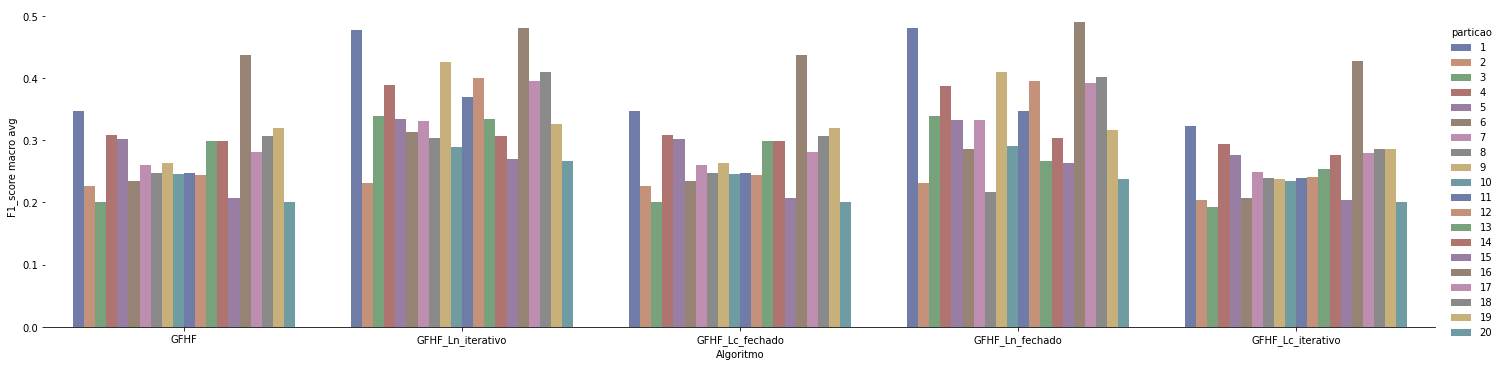

In [ ]:
#@title  
import seaborn as sns

df_resultados = pd.DataFrame(f1_score_Re0)
metodos=['GFHF', 'GFHF_Lc_fechado', 'GFHF_Lc_iterativo', 'GFHF_Ln_fechado', 'GFHF_Ln_iterativo']

df_resultados.columns = metodos
df_resultados['particao'] = df_resultados.index+1
df_resultados = pd.melt(df_resultados,
                        value_vars=metodos, 
                        id_vars='particao').sort_values('particao')

g = sns.catplot(
    data=df_resultados, kind="bar",
    x="variable", y="value", hue="particao",
    ci="sd", palette="dark", alpha=.6, height=5, aspect=20/5
)

g.set_axis_labels("Algoritmo", "F1_score macro avg")
g.despine(left=True)
# g.legend.set_title("")

## OSULeaf

### Leitura do Dataset

In [ ]:
import pandas as pd
osuleaf = pd.read_csv(CAMINHO_DATASETS+'/OSULeaf_DTW_BW.txt',header=None, sep=',')

In [ ]:
X_osuleaf = osuleaf.loc[:, 0:osuleaf.shape[1]-2].values
y_osuleaf = osuleaf[[osuleaf.shape[1]-1]]
y_osuleaf.columns = ['classe']
for i in np.unique(y_osuleaf.values):
  y_osuleaf['classe_'+str(i)] = 1*(y_osuleaf[['classe']] == i)
matriz_distancias_osuleaf = X_osuleaf

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

### Grafo de adjacência, para k = 88 - Â

In [ ]:
matriz_adjacencia_osuleaf = matriz_adjacencia(X_osuleaf, k = 88)

In [ ]:
matriz_adjacencia_osuleaf.sum(axis=1)

array([88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88,
       88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88,
       88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88,
       88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88,
       88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88,
       88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88,
       88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88,
       88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88,
       88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88,
       88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88,
       88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88,
       88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88,
       88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88,
       88, 88, 88, 88, 88

### Matriz de adjacência mútua - A

In [ ]:
matriz_adjacencia_mutua_osuleaf = np.minimum(matriz_adjacencia_osuleaf,matriz_adjacencia_osuleaf.transpose())

In [ ]:
qtd_vertices_isolados = 0
for i in range(matriz_adjacencia_mutua_osuleaf.shape[0]):
  qtd_vizinhos = (matriz_adjacencia_mutua_osuleaf[i] != 0).sum()
  if qtd_vizinhos == 0:
    qtd_vertices_isolados+=1
    print("vértice ",i,"está isolado")
print("qtd vértices isolados: ", qtd_vertices_isolados)

qtd vértices isolados:  0


### Estimando σ

In [ ]:
sigma_osuleaf = calculo_sigma(matriz_distancias_osuleaf, matriz_adjacencia_mutua_osuleaf)
print("σ =", sigma_osuleaf)

σ = 3.4779914808446453


### Matriz de pesos das arestas - W



In [ ]:
matriz_peso_arestas_osuleaf = calculo_matriz_pesos(matriz_adjacencia_mutua_osuleaf, #matriz adjacência
                                                  matriz_distancias_osuleaf,       #matriz de distâncias
                                                  sigma_osuleaf)                   #sigma

In [ ]:
matriz_peso_arestas_osuleaf.trace()

0.0

(array([  1.,   1.,   9.,  14.,  32.,  55.,  47.,  74.,  78., 131.]),
 array([ 1. ,  9.7, 18.4, 27.1, 35.8, 44.5, 53.2, 61.9, 70.6, 79.3, 88. ]),
 <a list of 10 Patch objects>)

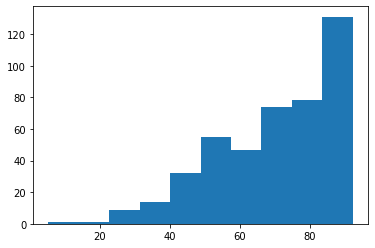

In [ ]:
import matplotlib.pyplot as plt

plt.hist(np.count_nonzero(matriz_peso_arestas_osuleaf,axis=1), align='right')


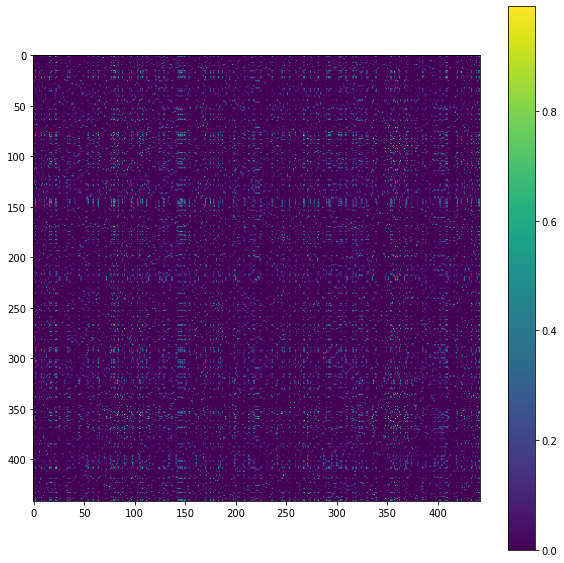

In [ ]:
import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(18, 2))

plt.figure(figsize = (10,10))
plt.imshow(matriz_peso_arestas_osuleaf)
plt.colorbar()

### Geração dos Laplacianos

In [ ]:
D_osuleaf = matriz_diagonal_pesos(matriz_peso_arestas_osuleaf)

In [ ]:
Lc_osuleaf = laplaciano_combinatorio(matriz_peso_arestas_osuleaf)
eigenvalues_Lc_osuleaf = np.linalg.eigvals(Lc_osuleaf)

In [ ]:
Ln_osuleaf = laplaciano_normalizado(matriz_peso_arestas_osuleaf)
eigenvalues_Ln_osuleaf = np.linalg.eigvals(Ln_osuleaf)

#### Gráficos

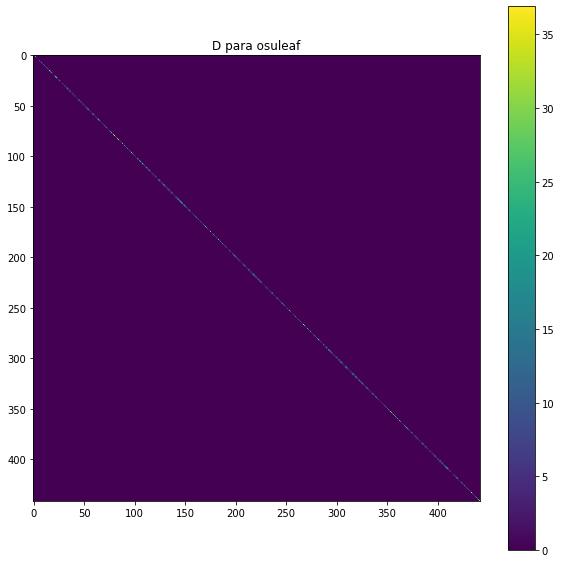

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(D_osuleaf)
plt.title('D para osuleaf')
plt.colorbar()

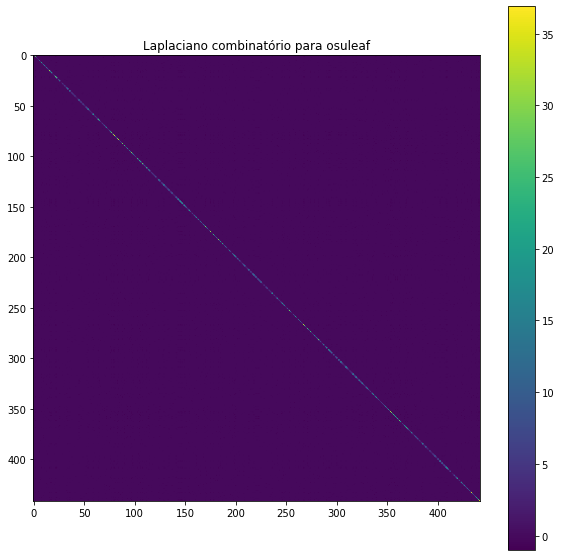

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(Lc_osuleaf)
plt.title('Laplaciano combinatório para osuleaf')
plt.colorbar()

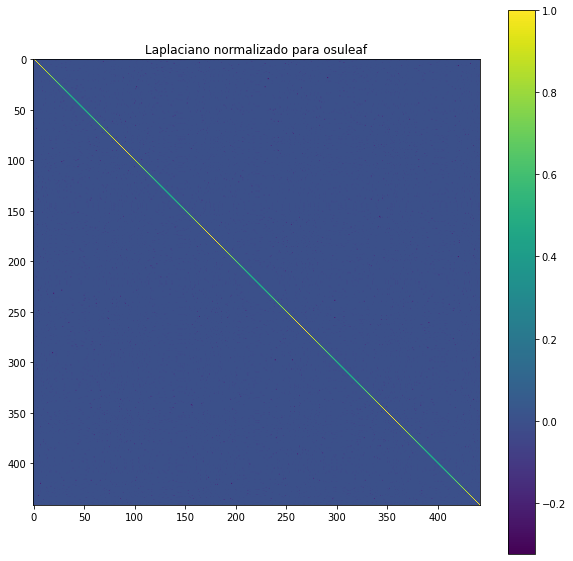

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(Ln_osuleaf)
plt.title('Laplaciano normalizado para osuleaf')
plt.colorbar()

### Matriz de transição

In [ ]:
P_osuleaf = matriz_transicao(D_osuleaf, matriz_peso_arestas_osuleaf)

### Aplicação da propagação de rótulos

In [ ]:
# leitura do arquivo de partições:
partitions_osuleaf = pd.read_csv(CAMINHO_DATASETS + '/partitions_OSULeaf_DTW_BW.txt',header=None, sep=',').values
partitions_osuleaf

array([[  6,  38,  49,  63,  66,  73,  80,  87, 141, 208, 229, 244, 261,
        292, 341, 348, 379, 420],
       [ 20,  64,  72,  75, 118, 135, 146, 154, 156, 184, 193, 196, 198,
        234, 304, 320, 377, 400],
       [ 59,  92, 126, 127, 143, 153, 162, 177, 210, 225, 238, 265, 278,
        298, 325, 363, 407, 415],
       [ 56,  61,  72,  83, 110, 122, 137, 154, 167, 179, 189, 245, 256,
        264, 306, 312, 378, 400],
       [ 11,  22,  34, 106, 109, 132, 234, 259, 261, 268, 302, 309, 321,
        331, 347, 356, 381, 383],
       [  1,  61,  78,  84, 129, 131, 146, 171, 172, 205, 234, 241, 246,
        322, 353, 359, 412, 417],
       [  1,  12,  65,  83, 137, 154, 167, 217, 246, 286, 293, 314, 347,
        371, 374, 398, 409, 424],
       [  1,  23,  99, 124, 126, 140, 141, 159, 171, 173, 196, 254, 313,
        373, 376, 420, 421, 424],
       [  5,  19,  82, 107, 165, 185, 199, 200, 219, 238, 240, 260, 278,
        301, 345, 373, 404, 405],
       [ 37,  53,  55, 100, 113, 149,

Para demonstrar a aplicação dos algoritmos será utilizada a primeira lista de índices fornecida para o dataset

In [ ]:
f1_score_osuleaf = {}

matriz_pesos = matriz_peso_arestas_osuleaf

particoes = partitions_osuleaf

labels = y_osuleaf.loc[particoes[0]]['classe']


print("índices das observações classificadas:",particoes[0])
print("Quantidade de observações com labels: ",particoes[0].shape[0])
print("Quantidade de observações sem labels: ",matriz_pesos.shape[0] - particoes[0].shape[0] )
print("Distribuição das classes: ")
print(labels.value_counts())

índices das observações classificadas: [  6  38  49  63  66  73  80  87 141 208 229 244 261 292 341 348 379 420]
Quantidade de observações com labels:  18
Quantidade de observações sem labels:  424
Distribuição das classes: 
0    6
3    4
2    3
1    3
5    1
4    1
Name: classe, dtype: int64


#### Solução pela "forma fechada"
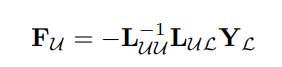

In [ ]:
particao = particoes[0]
L = reorganizar_matriz(Lc_osuleaf, particao)
Y = reorganizar_labels(y_osuleaf[y_osuleaf.columns[1:]].values, particao)
Luu =  L[3]
Lul =  L[2]
Yl = Y[0]

# checando formato das matrizes
print("Formato da Luu (submatriz de Lc das observações não classificadas): ")
print(Luu.shape)
print("Formato da Lul (submatriz de Lc que contém as linhas das observações não classifcadas e as colunas das observações classificadas): ")
print(Lul.shape)
print("Formato da Yl (submatriz de Y que contém as classificações conhecidas): ")
print(Yl.shape)

# Propagação das labels
Fu = - np.linalg.inv(Luu) @ Lul @ Yl

print("Formato de Fu (resultado): ")
print(Fu.shape)

# classificação final das labels desconhecidas
ŷ = np.argmax(Fu, axis=1)

print("Distribuição de classes do resultado:")
print(pd.Series(ŷ).value_counts())

Formato da Luu (submatriz de Lc das observações não classificadas): 
(424, 424)
Formato da Lul (submatriz de Lc que contém as linhas das observações não classifcadas e as colunas das observações classificadas): 
(424, 18)
Formato da Yl (submatriz de Y que contém as classificações conhecidas): 
(18, 6)
Formato de Fu (resultado): 
(424, 6)
Distribuição de classes do resultado:
3    279
2    106
0     22
1     17
dtype: int64


              precision    recall  f1-score   support

           0       0.77      0.28      0.41        60
           1       0.53      0.11      0.18        81
           2       0.27      0.40      0.33        72
           3       0.31      0.92      0.46        93
           4       0.00      0.00      0.00        81
           5       0.00      0.00      0.00        37

    accuracy                           0.33       424
   macro avg       0.31      0.29      0.23       424
weighted avg       0.32      0.33      0.25       424



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


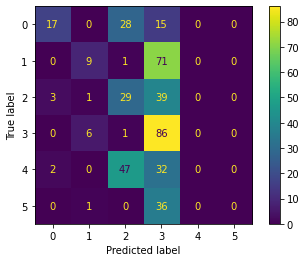

In [ ]:
#@markdown Classification report e matriz de confusão
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, plot_confusion_matrix

# classes alvo, correspondem às classes disponibilizadas, porém ignoradas para o teste

y = np.argmax(Y[1], axis=1)
lista_classes = np.unique(y)
# classes preditas após a difusão de labels
y_pred = ŷ

print(classification_report(y,y_pred))


class ClassificadorAdaptador(BaseEstimator, ClassifierMixin):

    def __init__(self, y):
        self.y = y
    def fit(self, X, y):
        return self
    def predict(self, X):
        return self.y[X]


# classificador para habilitar o uso da matriz de confusão
classificador = ClassificadorAdaptador(ŷ)

classificador.fit(range(ŷ.shape[0]),ŷ)

plot_confusion_matrix(classificador, 
                      range(ŷ.shape[0]), 
                      y, 
                      display_labels= lista_classes,
                      values_format= ".0f")

##### Aplicação da solução para todas as partições

In [ ]:
from sklearn.metrics import f1_score
lista_f1 = []
for particao in particoes:
  # reorganiza Lc
  L = reorganizar_matriz(Lc_osuleaf, particao)
  # reorganiza labels
  Y = reorganizar_labels(y_osuleaf[y_osuleaf.columns[1:]].values, particao)
  Luu =  L[3]
  Lul =  L[2]
  Yl = Y[0]
  Fu = - np.linalg.inv(Luu) @ Lul @ Yl
  # classificação final das labels desconhecidas
  ŷ = np.argmax(Fu, axis=1)

  # classificações verdadeiras
  y = np.argmax(Y[1], axis=1)
  lista_f1.append(f1_score(y,ŷ,average= 'macro'))
f1_score_osuleaf[0] = lista_f1

#### Soluções via Gaussian Fields and Harmonic Functions (GFHF)

##### GFHF para L = Lc

###### Cálculo da forma fechada
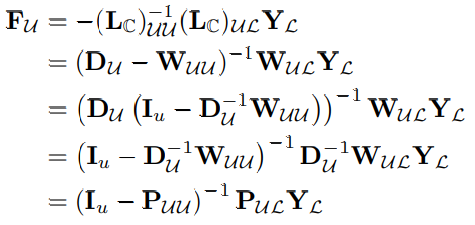

In [ ]:
particao = particoes[0]

# Matriz de transição dos elementos não classificados (uu):
P = reorganizar_matriz(P_osuleaf, particao )
Puu = P[3]

# Matriz de transição dos elementos não classificados e classificados (ul):
Pul = P[2]

# Matriz idendidade
Iu = np.eye(Puu.shape[0])

# submatriz das classes conhecidas
Y = reorganizar_labels(y_osuleaf[y_osuleaf.columns[1:]].values, particao)
Yl = Y[0]

# checando formato das matrizes

print("Formato da Iuu (matriz identidade de dimensões uxu): ")
print(Iu.shape)
print("Formato da Puu (submatriz de transição que contém as observações não classificadas): ")
print(Puu.shape)
print("Formato da Pul (submatriz de transição que contém as linhas das observações não classificadas e as colunas das observações classificadas): ")
print(Pul.shape)
print("Formato da Yl (submatriz de Y que contém as classificações conhecidas): ")
print(Yl.shape)


Fu = np.linalg.inv(Iu - Puu) @ Pul @ Yl
# classificação final das labels desconhecidas
ŷ = np.argmax(Fu, axis=1)

print("Formato de Fu (resultado): ")
print(Fu.shape)

print("Distribuição de classes do resultado:")
print(pd.Series(ŷ).value_counts())


Formato da Iuu (matriz identidade de dimensões uxu): 
(424, 424)
Formato da Puu (submatriz de transição que contém as observações não classificadas): 
(424, 424)
Formato da Pul (submatriz de transição que contém as linhas das observações não classificadas e as colunas das observações classificadas): 
(424, 18)
Formato da Yl (submatriz de Y que contém as classificações conhecidas): 
(18, 6)
Formato de Fu (resultado): 
(424, 6)
Distribuição de classes do resultado:
3    279
2    106
0     22
1     17
dtype: int64


              precision    recall  f1-score   support

           0       0.77      0.28      0.41        60
           1       0.53      0.11      0.18        81
           2       0.27      0.40      0.33        72
           3       0.31      0.92      0.46        93
           4       0.00      0.00      0.00        81
           5       0.00      0.00      0.00        37

    accuracy                           0.33       424
   macro avg       0.31      0.29      0.23       424
weighted avg       0.32      0.33      0.25       424



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


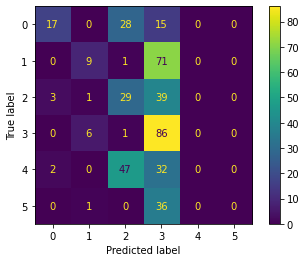

In [ ]:
#@markdown Classification report e matriz de confusão
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# classes alvo, correspondem às classes disponibilizadas, porém ignoradas para o teste
y =  np.argmax(Y[1], axis=1)
lista_classes = np.unique(y)
# classes preditas após a difusão de labels
y_pred = ŷ

print(classification_report(y,y_pred))


class ClassificadorAdaptador(BaseEstimator, ClassifierMixin):

    def __init__(self, y):
        self.y = y
    def fit(self, X, y):
        return self
    def predict(self, X):
        return self.y[X]


# classificador para habilitar o uso da matriz de confusão
classificador = ClassificadorAdaptador(ŷ)

classificador.fit(range(ŷ.shape[0]),ŷ)

plot_confusion_matrix(classificador, 
                      range(ŷ.shape[0]), 
                      y, 
                      display_labels= lista_classes,
                      values_format= ".0f")

###### Aplicação da solução para todas as partições

In [ ]:
from sklearn.metrics import f1_score
lista_f1 = []
for particao in particoes:
  # reorganiza matriz de transição
  P = reorganizar_matriz(P_osuleaf, particao)
  # reorganiza labels
  Y = reorganizar_labels(y_osuleaf[y_osuleaf.columns[1:]].values, particao)
  Puu = P[3]
  Pul = P[2]
  Yl = Y[0]
  # Matriz idendidade
  Iu = np.eye(Puu.shape[0])
  Fu = np.linalg.inv(Iu - Puu) @ Pul @ Yl
  # classificação final das labels desconhecidas
  ŷ = np.argmax(Fu, axis=1)

  # classificações verdadeiras
  y = np.argmax(Y[1], axis=1)
  lista_f1.append(f1_score(y,ŷ,average= 'macro'))
f1_score_osuleaf[1] = lista_f1

###### Cálculo iterativo
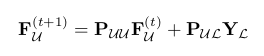

In [ ]:


particao = particoes[0]

# Matriz de transição dos elementos não classificados (uu):
P = reorganizar_matriz(P_osuleaf, particao )
Puu = P[3]

# Matriz de transição dos elementos não classificados e classificados (ul):
Pul = P[2]

# submatriz das classes conhecidas
Y = reorganizar_labels(y_osuleaf[y_osuleaf.columns[1:]].values, particao)
Yl = Y[0]

# inicialização das variáveis
Fu = np.zeros_like(Y[1])
v = Pul @ Yl
for i in range(max_iter):
  Fu = Puu @ Fu + v

# classificação final das labels desconhecidas
ŷ = np.argmax(Fu, axis=1)

print(Fu.shape)

print("Distribuição de classes do resultado:")

print(pd.Series(ŷ).value_counts())

(424, 6)
Distribuição de classes do resultado:
3    271
2    113
0     22
1     18
dtype: int64


              precision    recall  f1-score   support

           0       0.77      0.28      0.41        60
           1       0.50      0.11      0.18        81
           2       0.27      0.42      0.32        72
           3       0.31      0.91      0.47        93
           4       0.00      0.00      0.00        81
           5       0.00      0.00      0.00        37

    accuracy                           0.33       424
   macro avg       0.31      0.29      0.23       424
weighted avg       0.32      0.33      0.25       424



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


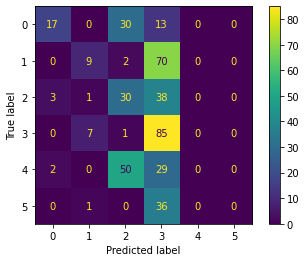

In [ ]:
#@markdown Classification report e matriz de confusão
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# classes alvo, correspondem às classes disponibilizadas, porém ignoradas para o teste
y =  np.argmax(Y[1], axis=1)
lista_classes = np.unique(y)
# classes preditas após a difusão de labels
y_pred = ŷ

print(classification_report(y,y_pred))


class ClassificadorAdaptador(BaseEstimator, ClassifierMixin):

    def __init__(self, y):
        self.y = y
    def fit(self, X, y):
        return self
    def predict(self, X):
        return self.y[X]


# classificador para habilitar o uso da matriz de confusão
classificador = ClassificadorAdaptador(ŷ)

classificador.fit(range(ŷ.shape[0]),ŷ)

plot_confusion_matrix(classificador, 
                      range(ŷ.shape[0]), 
                      y, 
                      display_labels= lista_classes,
                      values_format= ".0f")

###### Aplicação da solução para todas as partições

In [ ]:
from sklearn.metrics import f1_score
lista_f1 = []

for particao in particoes:
  # reorganiza matriz de transição
  P = reorganizar_matriz(P_osuleaf, particao)
  # reorganiza labels
  Y = reorganizar_labels(y_osuleaf[y_osuleaf.columns[1:]].values, particao)
  Puu = P[3]
  Pul = P[2]
  Yl = Y[0]

  # inicialização das variáveis
  Fu = np.zeros_like(Y[1])
  v = Pul @ Yl
  
  # convergência de Fu
  for i in range(max_iter):
    Fu = Puu @ Fu + v
  
  # classificação final das labels desconhecidas
  ŷ = np.argmax(Fu, axis=1)

  # classificações verdadeiras
  y = np.argmax(Y[1], axis=1)
  
  lista_f1.append(f1_score(y,ŷ, average= 'macro'))
f1_score_osuleaf[2] = lista_f1

##### GFHF para L = Ln

###### Cálculo da forma fechada
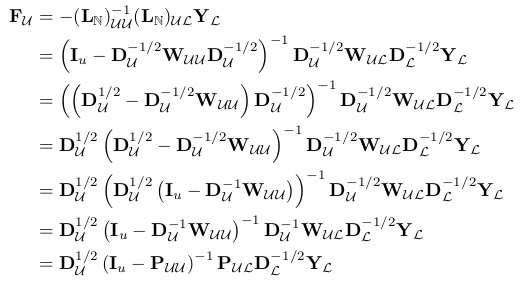

In [ ]:
particao = particoes[0]

# Matriz de transição dos elementos não classificados (uu):
P = reorganizar_matriz(P_osuleaf, particao )
Puu = P[3]

# Matriz de transição dos elementos não classificados e classificados (ul):
Pul = P[2]

# Matriz idendidade
Iu = np.eye(Puu.shape[0])

# D
D = reorganizar_matriz(D_osuleaf, particao)

Dll = np.diag(np.diag(D[0]) ** -0.5) # cálculo da raiz quadrada da inversa de Dll
Duu = np.diag(np.diag(D[3]) ** 0.5) # cálculo da raiz quadrada de Duu

# submatriz das classes conhecidas
Y = reorganizar_labels(y_osuleaf[y_osuleaf.columns[1:]].values, particao)
Yl = Y[0]

Fu = Duu @ np.linalg.inv(Iu - Puu) @ Pul @ Dll @ Yl
# classificação final das labels desconhecidas
ŷ = np.argmax(Fu, axis=1)

print("Formato de Fu (resultado): ")
print(Fu.shape)

print("Distribuição de classes do resultado:")
print(pd.Series(ŷ).value_counts())


Formato de Fu (resultado): 
(424, 6)
Distribuição de classes do resultado:
0    140
1    130
3     96
2     55
5      3
dtype: int64


              precision    recall  f1-score   support

           0       0.40      0.93      0.56        60
           1       0.33      0.53      0.41        81
           2       0.42      0.32      0.36        72
           3       0.41      0.42      0.41        93
           4       0.00      0.00      0.00        81
           5       0.33      0.03      0.05        37

    accuracy                           0.38       424
   macro avg       0.31      0.37      0.30       424
weighted avg       0.31      0.38      0.31       424



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


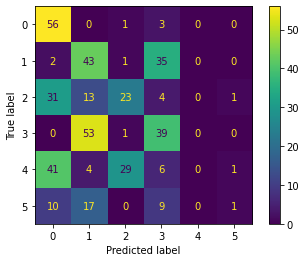

In [ ]:
#@markdown Classification report e matriz de confusão
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# classes alvo, correspondem às classes disponibilizadas, porém ignoradas para o teste
y =  np.argmax(Y[1], axis=1)
lista_classes = np.unique(y)
# classes preditas após a difusão de labels
y_pred = ŷ

print(classification_report(y,y_pred))


class ClassificadorAdaptador(BaseEstimator, ClassifierMixin):

    def __init__(self, y):
        self.y = y
    def fit(self, X, y):
        return self
    def predict(self, X):
        return self.y[X]


# classificador para habilitar o uso da matriz de confusão
classificador = ClassificadorAdaptador(ŷ)

classificador.fit(range(ŷ.shape[0]),ŷ)

plot_confusion_matrix(classificador, 
                      range(ŷ.shape[0]), 
                      y, 
                      display_labels= lista_classes,
                      values_format= ".0f")

###### Aplicação da solução para todas as partições

In [ ]:
from sklearn.metrics import f1_score
lista_f1 = []
for particao in particoes:
  # reorganiza matriz de transição
  P = reorganizar_matriz(P_osuleaf, particao)
  # reorganiza labels
  Y = reorganizar_labels(y_osuleaf[y_osuleaf.columns[1:]].values, particao)
  
  Puu = P[3]
  
  Pul = P[2]
  
  Yl = Y[0]
  # D
  D = reorganizar_matriz(D_osuleaf, particao)

  Dll = np.diag(np.diag(D[0]) ** -0.5) # cálculo da raiz quadrada da inversa de Dll
  Duu = np.diag(np.diag(D[3]) ** 0.5) # cálculo da raiz quadrada de Duu
  
  Iu = np.eye(Puu.shape[0])

  Fu = Duu @ np.linalg.inv(Iu - Puu) @ Pul @ Dll @ Yl
  # classificação final das labels desconhecidas
  ŷ = np.argmax(Fu, axis=1)

  # classificações verdadeiras
  y = np.argmax(Y[1], axis=1)
  lista_f1.append(f1_score(y,ŷ,average= 'macro'))
f1_score_osuleaf[3] = lista_f1

###### Cálculo iterativo
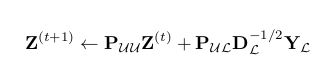

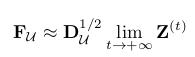

In [ ]:


particao = particoes[0]

# Matriz de transição dos elementos não classificados (uu):
P = reorganizar_matriz(P_osuleaf, particao )
Puu = P[3]

# Matriz de transição dos elementos não classificados e classificados (ul):
Pul = P[2]

# Matriz idendidade
Iu = np.eye(Puu.shape[0])

# D
D = reorganizar_matriz(D_osuleaf, particao)

Dll = np.diag(np.diag(D[0]) ** -0.5) # cálculo da raiz quadrada da inversa de Dll
Duu = np.diag(np.diag(D[3]) ** 0.5) # cálculo da raiz quadrada de Duu

# submatriz das classes conhecidas
Y = reorganizar_labels(y_osuleaf[y_osuleaf.columns[1:]].values, particao)
Yl = Y[0]

# inicialização das variáveis
Fu = np.zeros_like(Y[1])
v = Pul @ Dll @ Yl
for i in range(max_iter):
  Fu = Puu @ Fu + v

Fu = Duu @ Fu
# classificação final das labels desconhecidas
ŷ = np.argmax(Fu, axis=1)

print(Fu.shape)

print("Distribuição de classes do resultado:")

print(pd.Series(ŷ).value_counts())

(424, 6)
Distribuição de classes do resultado:
0    140
1    130
3     96
2     55
5      3
dtype: int64


              precision    recall  f1-score   support

           0       0.40      0.93      0.56        60
           1       0.33      0.53      0.41        81
           2       0.42      0.32      0.36        72
           3       0.41      0.42      0.41        93
           4       0.00      0.00      0.00        81
           5       0.33      0.03      0.05        37

    accuracy                           0.38       424
   macro avg       0.31      0.37      0.30       424
weighted avg       0.31      0.38      0.31       424



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


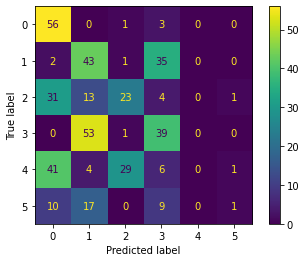

In [ ]:
#@markdown Classification report e matriz de confusão
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# classes alvo, correspondem às classes disponibilizadas, porém ignoradas para o teste
y =  np.argmax(Y[1], axis=1)
lista_classes = np.unique(y)
# classes preditas após a difusão de labels
y_pred = ŷ

print(classification_report(y,y_pred))


class ClassificadorAdaptador(BaseEstimator, ClassifierMixin):

    def __init__(self, y):
        self.y = y
    def fit(self, X, y):
        return self
    def predict(self, X):
        return self.y[X]


# classificador para habilitar o uso da matriz de confusão
classificador = ClassificadorAdaptador(ŷ)

classificador.fit(range(ŷ.shape[0]),ŷ)

plot_confusion_matrix(classificador, 
                      range(ŷ.shape[0]), 
                      y, 
                      display_labels=lista_classes,
                      values_format= ".0f")

###### Aplicação da solução para todas as partições

In [ ]:
from sklearn.metrics import f1_score
lista_f1 = []

for particao in particoes:
  # Matriz de transição dos elementos não classificados (uu):
  P = reorganizar_matriz(P_osuleaf, particao )
  Puu = P[3]

  # Matriz de transição dos elementos não classificados e classificados (ul):
  Pul = P[2]

  # Matriz idendidade
  Iu = np.eye(Puu.shape[0])

  # D
  D = reorganizar_matriz(D_osuleaf, particao)

  Dll = np.diag(np.diag(D[0]) ** -0.5) # cálculo da raiz quadrada da inversa de Dll
  Duu = np.diag(np.diag(D[3]) ** 0.5) # cálculo da raiz quadrada de Duu

  # submatriz das classes conhecidas
  Y = reorganizar_labels(y_osuleaf[y_osuleaf.columns[1:]].values, particao)
  Yl = Y[0]

  # inicialização das variáveis
  Fu = np.zeros_like(Y[1])
  v = Pul @ Dll @ Yl
  for i in range(max_iter):
    Fu = Puu @ Fu + v

  Fu = Duu @ Fu
  # classificação final das labels desconhecidas
  ŷ = np.argmax(Fu, axis=1)

  # classificações verdadeiras
  y = np.argmax(Y[1], axis=1)
  
  lista_f1.append(f1_score(y,ŷ, average= 'macro'))
f1_score_osuleaf[4] = lista_f1

#### Avaliação dos resultados

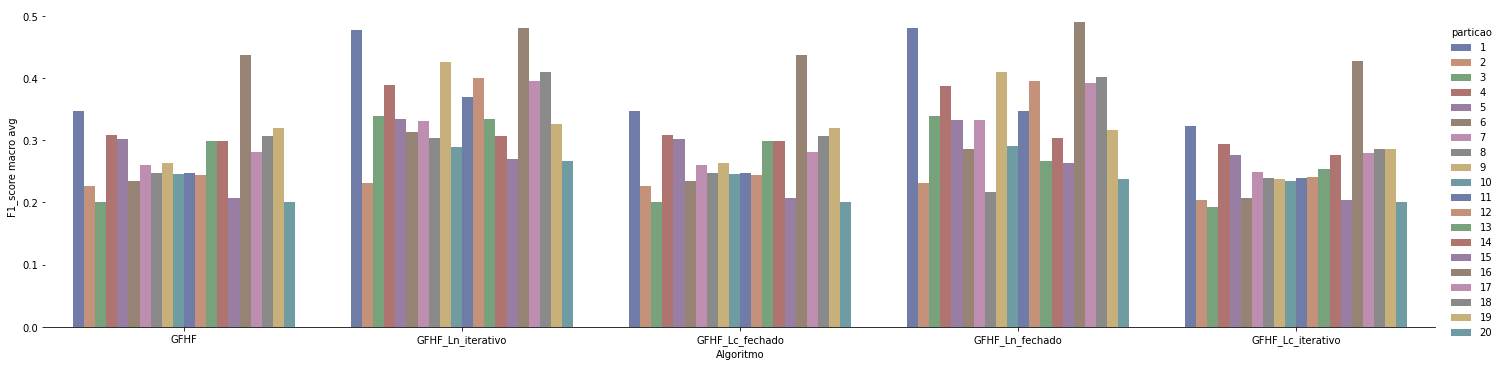

In [ ]:
#@title  
import seaborn as sns

df_resultados = pd.DataFrame(f1_score_Re0)
metodos=['GFHF', 'GFHF_Lc_fechado', 'GFHF_Lc_iterativo', 'GFHF_Ln_fechado', 'GFHF_Ln_iterativo']

df_resultados.columns = metodos
df_resultados['particao'] = df_resultados.index+1
df_resultados = pd.melt(df_resultados,
                        value_vars=metodos, 
                        id_vars='particao').sort_values('particao')

g = sns.catplot(
    data=df_resultados, kind="bar",
    x="variable", y="value", hue="particao",
    ci="sd", palette="dark", alpha=.6, height=5, aspect=20/5
)

g.set_axis_labels("Algoritmo", "F1_score macro avg")
g.despine(left=True)
# g.legend.set_title("")